# Проект "Телеком"
**Задача проекта**

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# Первичный анализ данных

In [675]:
import category_encoders as ce
import lightgbm as lgb
import numpy as np
import pandas as pd
import phik
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from pandas.api.types import is_string_dtype

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import (
    make_column_transformer,
    make_column_selector
)
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold
)
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    FunctionTransformer
)
from sklearn.impute import SimpleImputer



warnings.simplefilter('ignore')

plt.style.use("ggplot")
plt.rcParams["axes.labelweight"] = "bold"

In [676]:
def info_df(df):
    for column in df.columns:
        print('='*20)
        print('Столбец:', '\033[1m', column + '\033[0m')
        print('='*20)
        print(
            'Кол-во уникальны значений в столбце:',
            '\033[1m', df[column].nunique(), '\033[0m'
        )
        print(df[column].unique()[:5])

## Информация о договорах

In [778]:
try:
    contract = pd.read_csv('contract_new.csv')
except:
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')

In [779]:
contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [679]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [680]:
contract.duplicated().sum()

0

In [681]:
contract.customerID.duplicated().sum()

0

В данных 7043 уникальных объекта и 8 признаков.\
Пропусков, полных дубликатов и дубликатов ID клиентов в данных нет.\
**Неверные форматы:** \
BeginDate и EndDate храняться в формате object.\
TotalCharges также в формате object.

In [682]:
info_df(contract)

Столбец:  customerID
Кол-во уникальны значений в столбце:  7043 
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' '7795-CFOCW' '9237-HQITU']
Столбец:  BeginDate
Кол-во уникальны значений в столбце:  77 
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01']
Столбец:  EndDate
Кол-во уникальны значений в столбце:  67 
['No' '2017-05-01' '2016-03-01' '2018-09-01' '2018-11-01']
Столбец:  Type
Кол-во уникальны значений в столбце:  3 
['Month-to-month' 'One year' 'Two year']
Столбец:  PaperlessBilling
Кол-во уникальны значений в столбце:  2 
['Yes' 'No']
Столбец:  PaymentMethod
Кол-во уникальны значений в столбце:  4 
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Столбец:  MonthlyCharges
Кол-во уникальны значений в столбце:  1585 
[29.85 56.95 53.85 42.3  70.7 ]
Столбец:  TotalCharges
Кол-во уникальны значений в столбце:  6658 
['31.04' '2071.84' '226.17' '1960.6' '353.5']


В столбцах BeginDate и EndDate содержится слишком много категориальных признаков. Из них нужно выделить два новых признака: количество дней, сколько объект является клиентом компании и **целевой признак** - был ли договор расторгнут или нет.  

## Персональная информация о клиентах.

In [780]:
try:
    personal = pd.read_csv('personal_new.csv')
except:
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')

In [683]:
personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [684]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [685]:
personal.duplicated().sum()

0

In [686]:
personal.customerID.duplicated().sum()

0

В данных 7043 уникальных объекта и 5 признаков.\
Пропусков, полных дубликатов и дубликатов ID клиентов в данных нет.\
**Неверные форматы:**
нет

In [687]:
info_df(personal)

Столбец:  customerID
Кол-во уникальны значений в столбце:  7043 
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' '7795-CFOCW' '9237-HQITU']
Столбец:  gender
Кол-во уникальны значений в столбце:  2 
['Female' 'Male']
Столбец:  SeniorCitizen
Кол-во уникальны значений в столбце:  2 
[0 1]
Столбец:  Partner
Кол-во уникальны значений в столбце:  2 
['Yes' 'No']
Столбец:  Dependents
Кол-во уникальны значений в столбце:  2 
['No' 'Yes']


В данных 4 категориальных столбца, в каждом по две категории.

## Данные об интернет-услугах, оказываемых клиентам.

In [ ]:
try:
    internet = pd.read_csv('internet_new.csv')
except:
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')

In [688]:
internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [689]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [690]:
internet.duplicated().sum()

0

In [691]:
internet.customerID.duplicated().sum()

0

В данных 5517 уникальных объекта и 8 признаков.\
Пропусков, полных дубликатов и дубликатов ID клиентов в данных нет.\
**Неверные форматы:**
нет

In [692]:
info_df(internet)

Столбец:  customerID
Кол-во уникальны значений в столбце:  5517 
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' '7795-CFOCW' '9237-HQITU']
Столбец:  InternetService
Кол-во уникальны значений в столбце:  2 
['DSL' 'Fiber optic']
Столбец:  OnlineSecurity
Кол-во уникальны значений в столбце:  2 
['No' 'Yes']
Столбец:  OnlineBackup
Кол-во уникальны значений в столбце:  2 
['Yes' 'No']
Столбец:  DeviceProtection
Кол-во уникальны значений в столбце:  2 
['No' 'Yes']
Столбец:  TechSupport
Кол-во уникальны значений в столбце:  2 
['No' 'Yes']
Столбец:  StreamingTV
Кол-во уникальны значений в столбце:  2 
['No' 'Yes']
Столбец:  StreamingMovies
Кол-во уникальны значений в столбце:  2 
['No' 'Yes']


В данных 7 категориальных столбцов, в каждом по две категории.

## Данные об услугах телефонии, оказываемых клиентам

In [781]:
try:
    internet = pd.read_csv('phone_new.csv')
except:
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

In [693]:
phone.head(5)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [694]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [695]:
phone.duplicated().sum()

0

In [696]:
phone.customerID.duplicated().sum()

0

В данных 6361 уникальных объекта и 5 признаков.\
Пропусков, полных дубликатов и дубликатов ID клиентов в данных нет.\
**Неверные форматы:**
нет

In [697]:
info_df(phone)

Столбец:  customerID
Кол-во уникальны значений в столбце:  6361 
['5575-GNVDE' '3668-QPYBK' '9237-HQITU' '9305-CDSKC' '1452-KIOVK']
Столбец:  MultipleLines
Кол-во уникальны значений в столбце:  2 
['No' 'Yes']


В данных один категориальный признак с двумя категориями.

## Итоги первичного анализа

Имеются данные о 7043 клиентах компании. 
Для каждого известна следующая информация:

1. **Информация о договорах**
* Дата заключения договора
* Дата расторжения договора. Если дата отсутствует, это означает, что договор не был расторгнут на момент выгрузки данных.
* Тип договора: на месяц, на один год, на два года.
* Наличие бумажной счет-фактуры
* Способ оплаты: Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic).
* Ежемесячные сборы
* Общая сумма сборов
2. **Персональная информация о клиентах.**
* Пол
* Относится ли клиент к гражданам старшего возраста
* Семейное положение
* Наличие иждивенцев
3. **Данные об интернет-услугах, оказываемых клиентам.**
* Вид подключения к интернету
* Пользуется ли клиент услугой блокировки небезопасных сайтов
* Пользуется ли клиент услугой облачного хранилища
* Пользуется ли клиент услугой антивируса
* Пользуется ли клиент услугой выделенной линии техподдержки
* Пользуется ли клиент услугой стримингового телевидения
* Пользуетья ли клиент услугой каталога фильмов
4. **Данные об услугах телефонии, оказываемых клиентам**
* Пользуется ли клиент услугой возможности ведения параллельных линий во время звонка

В каждой из таблиц так-же есть столбец с уникальными ID клиента.\
Количество строк в таблицах с данными об интернет-услугах и услугах телефонии различается, что говорит о том, что не все клиенты пользуются всеми услугами компании.


## План работы

1. **Подготовка данных и EDA**
* Определить переменную today, присвоив ей дату выгрузки данных: 1 февраля 2020г. В дальнейшем этой переменной можно будет присвоить текущую дату.
* Определить константы.
* Написать class, который с помощью scikit-learn приведет столбцы BeginDate и EndDate к формату date и преобразует значения столбца BeginDate в количество дней, сколько объект является клиентом компании. 
* Выделить целевой признак из столбца EndDate
* Объединить все таблицы в одну по столбцу customerID
* Удалить столбец customerID.
* Определить категориальные и численные признаки
* Заменить пропуски в категориальных признаках на Unknown. Это новая категория означает, что клиент не пользуеться определенной услугой.
* Исследовать корреляцию признаков.
* Проанализировать распределение признаков.
* Исследовать дисбаланс классов целевого признака.
* Пишем вывод
2. **Обучение моделей**
* Разделить данные на обучающую и тестовую выборки с учетом дисбаланса классов.
* Прописать несколько вариантов make_column_transformer с разными алгоритмами кодирования категориальных признаков. Использовать TargetEncoder и OneHotEncoder из библиотеки scikit-learn.
* Прописать pipeline и используя GridSearchCV подобрать сочетания кодировщика, модели и гиперпараметров. Использовать LogisticRegression и RandomForestClassifier из библиотеки scikit-learn и LightGBM. Оптимизацию производить по метрике ROC-AUC, при этом отслеживать значение метрики Accuracy.
* Вывести результаты в виде таблицы с топ-5 лучших комбинаций кодировщика, модели и гиперпараметров по значению ключевой метрики.
* Создать итоговую таблицу, содержащую все комбинации обучаемых моделей и кодировщиков и значения метрик ROC-AUC и Accuracy для этих комбинаций.
* Тестируем лучшую модель на тестовой выборке.
* Анализируем важность признаков лучшей модели.
* Делаем анализ матрицы ошибок.
3. **Общий вывод**
* Описать ключевые шаги работы над проектом.
* Провести анализ соответствия фактической работы запланированным шагам.
* Описание путей решения сложных моментов.
* Привести итоговый список признаков для обучения модели с описанием способов их обработки.
* Краткое описание предобработки данных.
* Вставить итоговую таблицу, содержащую все комбинации обучаемых моделей и кодировщиков и значения метрик ROC-AUC и Accuracy для этих комбинаций. 
* Указать лучшую комбинацию модели и энкодера - название, гиперпараметры, значения метрик на кросс-валидации.
* Указать итоговые метрики на тестовой выборке.
* Вывести матрицу ошибок с комментариями.
* Вывести график важности признаков с комментариями.

## Вопросы для уточнения
Нет вопросов

# Подготовка данных и EDA

In [698]:
TODAY = '2020-02-01'

RANDOM_STATE = 50623

SCV = StratifiedKFold(n_splits=5)

In [699]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False




# график для признака, содержащего более двух категорий
class MultiFeaturesChart:
    def addlabels(self, x, y, t=[]):
        for i in range(len(x)):
            plt.text(
                i,
                y[i],
                y[i],
                ha='center',
                bbox=dict(
                    facecolor='yellow',
                    alpha=.5
                ),
                size=15
            )
    def add_perc_labels(self, x, y, perc):
        for i in range(len(x)):
            if perc[i]*100 <= 5:
                color = 'green'
            elif perc[i]*100 <= 15:
                color = 'yellow'
            elif perc[i]*100 <= 20:
                color = 'orange'
            else:
                color = 'red'
            plt.text(
                i,
                perc[i]*max(y)+self.height_points,
                "{:.1%}".format(perc[i]),
                bbox=dict(
                    facecolor= color,
                    alpha = 0.5
                ),
                size=20
            )

    
    def config(
        self,
        df,
        x=None,
        line_height=1000,
        height_points=1300,
        title='Название таблицы',
        ylabel='Ось y',
        xlabel='Ось X',
        xticks_rotation=10,
        legend=['vol1', 'vol2', 'vol3', 'vol4'],
        legend_loc='best'
    ):
        self.df = df
        if x == None:
            self.x = self.df.columns.tolist()
        else:
            self.x = x
            
        self.line_height = line_height
        self.height_points = height_points
        self.title = title
        self.ylabel = ylabel
        self.xlabel = xlabel
        self.legend = legend
        self.xticks_rotation = xticks_rotation
        self.legend_loc = legend_loc
         

    def show(self):       
                       
        plt.figure(figsize=(19, 8))
        y = self.df.sum().reset_index(drop=True)
        
        plt.bar(self.x, y, edgecolor="black", alpha=.5)
        
        perc = (self.df[1:2] / self.df.sum()).T[1].reset_index(drop=True)
        
        plt.plot(self.x, perc*max(y)+self.line_height, color="green", linewidth=2)
        plt.plot(self.x, perc*max(y)+self.line_height, '*', color="green")
        
        self.addlabels(self.x, y)
        self.add_perc_labels(self.x, y, perc)
        
        y = self.df[1:2].sum()
        
        plt.bar(self.x, y, edgecolor="blue", color="blue", alpha =.5)
        
        plt.title(self.title, fontsize=18)
        plt.ylabel(self.ylabel)
        plt.xlabel(self.xlabel, fontsize=15)
        plt.legend(self.legend, fontsize=11, loc=self.legend_loc)
        plt.xticks(size=15, rotation=self.xticks_rotation)
        plt.yticks(size=15)
        
        plt.show();

# график для признака, содержащего не более двух категорий
class TwoFeaturesChart:
    
    def addlabels(self, x, y, t=[]):
        for i in range(len(x)):
            plt.text(
                i+0.18,
                y[i]-180,
                y[i],
                ha='center',
                bbox=dict(
                    facecolor='white',
                    alpha=.5
                ),
                size=20
            )
        
    def add_perc_labels(self, x, y, perc):
        for i in range(len(x)):
            if perc[i]*100 <= 5:
                color = 'green'
            elif perc[i]*100 <= 15:
                color = 'yellow'
            elif perc[i]*100 <= 25:
                color = 'orange'
            else:
                color = 'red'
                
            plt.text(
                i-0.15,
                y[i]+100,
                "{:.1%}".format(perc[i]), 
                bbox=dict(
                    facecolor=color,
                    alpha=0.3
                ),
                size=20
            )

    def config(
        self,
        df,
        x=None,
        title='Название таблицы',
        ylabel='Ось y',
        xlabel='Ось X',
        xticks_rotation=10,
        legend=['vol1', 'vol2', 'vol3', 'vol4'],
        legend_loc='best'
    ):
        self.df = df
        if x == None:
            self.x = self.df.columns.tolist()
        else:
            self.x = x

        self.title = title
        self.ylabel = ylabel
        self.xlabel = xlabel
        self.legend = legend
        self.xticks_rotation = xticks_rotation
        self.legend_loc = legend_loc

    def show(self):

        plt.figure(figsize=(19, 8))

        y = self.df.sum().reset_index(drop=True)
        plt.bar(
            self.x,
            y, edgecolor="black",
            width=0.35,
            align='edge',
            alpha=.5
        )

        perc = (self.df[1:2] / self.df.sum()).T[1].reset_index(drop=True)

        self.addlabels(self.x, y)

        y = self.df[1:2].sum()
        plt.bar(
            self.x,
            y,
            edgecolor="blue",
            color="blue",
            width=-0.35,
            align='edge',
            alpha=.5
        )

        self.add_perc_labels(self.x,y,perc)

        plt.title(self.title, fontsize=18)
        plt.ylabel(self.ylabel)
        plt.xlabel(self.xlabel, fontsize=15)
        plt.legend(self.legend, fontsize=11, loc=self.legend_loc)
        plt.xticks(size=15, rotation=self.xticks_rotation)
        plt.yticks(size=15)

        plt.show();


## Выделяем целевой признак

In [700]:
contract['target'] = contract['EndDate'].apply(lambda x: 1 if x != 'No' else 0)

In [701]:
info_df(contract[['target']])

Столбец:  target
Кол-во уникальны значений в столбце:  2 
[0 1]


In [702]:
contract['target'].mean()

0.15632542950447254

**15,6%** из всех клиентов компании расторгли договор

## Объединяем таблицы

In [703]:
df = contract.merge(personal, on='customerID', how='left')
df = df.merge(internet, on='customerID', how='left')
df = df.merge(phone, on='customerID', how='left')

In [704]:
df.shape

(7043, 21)

In [705]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


## Отделяем тестовую выборку

In [706]:
data, test = train_test_split(
    df,
    train_size=.75,
    random_state=RANDOM_STATE,
    stratify=df['target']
)

In [707]:
print('Размер обучающей выборки:', data.shape)
print('Размер тестовой выборки:',test.shape)
print('Баланс классов обучающей выборки:', data.target.mean())
print('Баланс классов тестовой выборки:', test.target.mean())

Размер обучающей выборки: (5282, 21)
Размер тестовой выборки: (1761, 21)
Баланс классов обучающей выборки: 0.1563801590306702
Баланс классов тестовой выборки: 0.15616127200454288


In [708]:
#данные для обучения моделей
initial_data = data.copy()

Исправим тип данных в TotalCharges

In [709]:
data.TotalCharges = data.TotalCharges.apply(
    lambda x: 0 if not is_number(x) else x
)

data.TotalCharges = data.TotalCharges.astype(float)


In [710]:
data.TotalCharges

1170    8536.32
1081    4547.10
616      202.00
105      130.00
3696     416.79
         ...   
5928    1204.75
1832    1555.40
2401     600.05
2234    1455.49
6391    3000.10
Name: TotalCharges, Length: 5282, dtype: float64

Создадим новый признак: количество дней, сколько клиент в компании. Он понадобится для исследовательского анализа. 

In [711]:
data.loc[data['EndDate'] == 'No', 'EndDate'] = TODAY
data['EndDate'] = pd.to_datetime(data['EndDate'])
data['BeginDate'] = pd.to_datetime(data['BeginDate'])

data['duration'] = (data['EndDate'] - data['BeginDate']).dt.days


In [712]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,gender,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration
1170,9127-FHJBZ,2014-02-01,2020-02-01,Two year,Yes,Electronic check,114.00,8536.32,0,Male,...,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2191
1081,1751-NCDLI,2016-04-01,2020-02-01,Month-to-month,Yes,Electronic check,98.85,4547.10,0,Male,...,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,1401
616,6464-KEXXH,2019-06-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),25.25,202.00,0,Male,...,No,DSL,No,No,No,No,No,No,NaN,245
105,6180-YBIQI,2019-09-01,2020-02-01,Month-to-month,No,Mailed check,24.30,130.00,0,Male,...,No,DSL,No,No,No,No,No,No,NaN,153
3696,3144-AUDBS,2019-06-01,2020-02-01,Month-to-month,Yes,Electronic check,49.15,416.79,0,Female,...,No,DSL,No,No,No,Yes,No,No,No,245


In [713]:
data = data.drop(
    columns=[
        'customerID',
        'BeginDate',
        'EndDate'
    ]
)


In [714]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 1170 to 6391
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5282 non-null   object 
 1   PaperlessBilling  5282 non-null   object 
 2   PaymentMethod     5282 non-null   object 
 3   MonthlyCharges    5282 non-null   float64
 4   TotalCharges      5282 non-null   float64
 5   target            5282 non-null   int64  
 6   gender            5282 non-null   object 
 7   SeniorCitizen     5282 non-null   int64  
 8   Partner           5282 non-null   object 
 9   Dependents        5282 non-null   object 
 10  InternetService   4169 non-null   object 
 11  OnlineSecurity    4169 non-null   object 
 12  OnlineBackup      4169 non-null   object 
 13  DeviceProtection  4169 non-null   object 
 14  TechSupport       4169 non-null   object 
 15  StreamingTV       4169 non-null   object 
 16  StreamingMovies   4169 non-null   objec

## Выделяем категориальные и численные признаки

In [715]:
categorical_features = [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'MultipleLines'
]

numeric_features = [
    'MonthlyCharges',
    'TotalCharges',
    'duration'
]

## Заменяем пропуски в категориальных признака на 'unknown'

In [716]:
data[categorical_features] = data[categorical_features].fillna('unknown')

In [717]:
data[categorical_features].isna().sum().sum()

0

## Исследовательский анализ

### Исследуем корреляцию признаков всего датасета

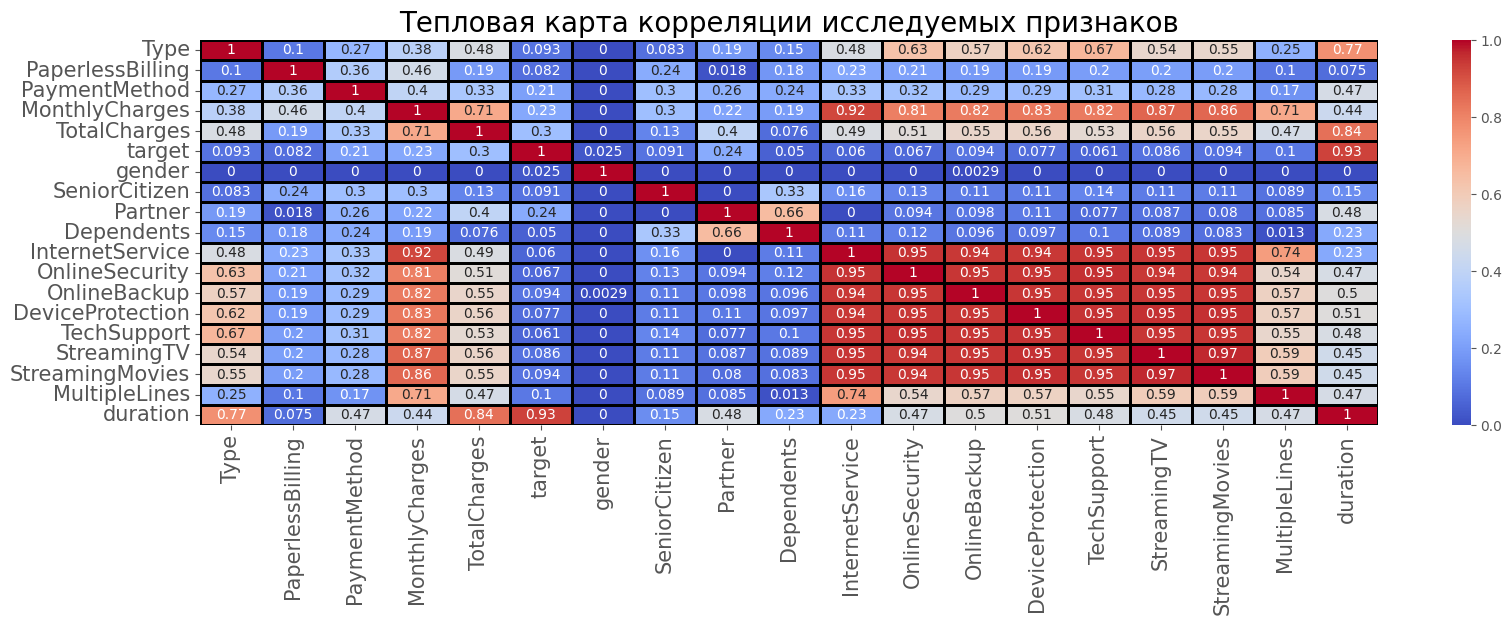

In [718]:
plt.figure(figsize=(19, 5))


sns.heatmap(
    data.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges']),
    annot=True,
    linewidths=2,
    linecolor='black',
    cmap='coolwarm'
);

plt.title('Тепловая карта корреляции исследуемых признаков', size=20)
plt.xticks(size=15)
plt.yticks(size=15)

plt.show();

Компания оказывает два основных типа услуг:
* Телефония
* Интернет

Наибольшая корреляция целевого признака с общей суммой трат клиента.

### Исследуем корреляция целевого признака с общей суммой трат клиента (по всем клиентам)

**Разобьем данные в столбце TotalCharges на 10 категорий и изучим распределение целевого признака в каждой из них.**

In [719]:
target_TotalCharges = data[
    [
        'target',
        'TotalCharges'
    ]
].hist2d(
    interval_cols=['TotalCharges'],
    bins={'TotalCharges': 10}
).reset_index(drop=True)
target_TotalCharges

TotalCharges,1,2,3,4,5,6,7,8,9,10
0,1959.0,826.0,405.0,315.0,254.0,199.0,195.0,147.0,114.0,42.0
1,178.0,186.0,147.0,132.0,103.0,43.0,26.0,8.0,3.0,0.0


Определим границы категорий

In [720]:
hist, bin_edges = np.histogram(data.TotalCharges)
bin_edges

array([   0.   ,  922.138, 1844.276, 2766.414, 3688.552, 4610.69 ,
       5532.828, 6454.966, 7377.104, 8299.242, 9221.38 ])

Построим график распределения

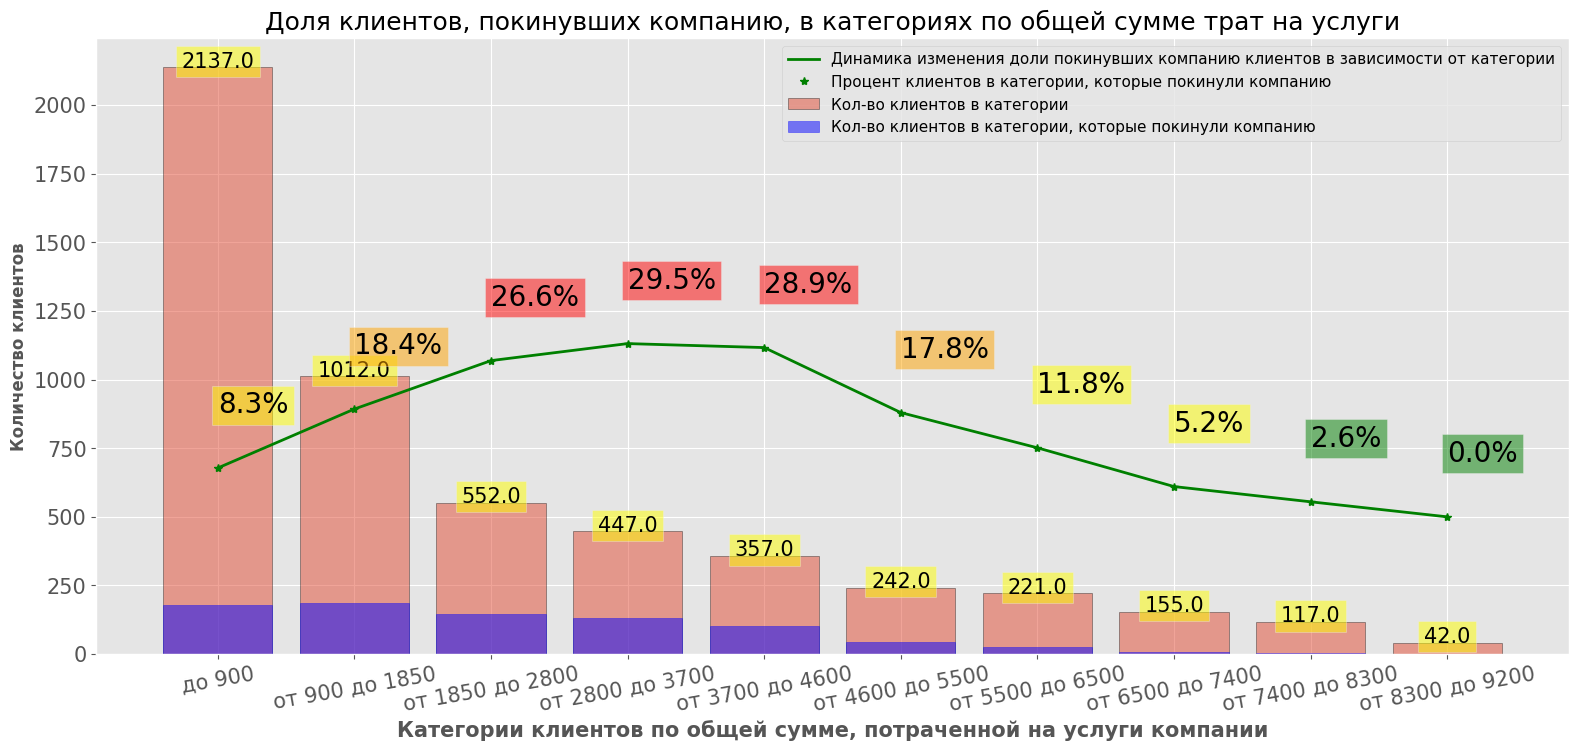

In [721]:
target_TotalCharges_chart = MultiFeaturesChart()

x = [
    'до 900', 'от 900 до 1850',
    'от 1850 до 2800', 'от 2800 до 3700',
    'от 3700 до 4600', 'от 4600 до 5500',
    'от 5500 до 6500', 'от 6500 до 7400',
    'от 7400 до 8300', 'от 8300 до 9200'
]

title = 'Доля клиентов, покинувших компанию, в категориях по общей сумме трат на услуги'
ylabel = 'Количество клиентов'
xlabel = 'Категории клиентов по общей сумме, потраченной на услуги компании'

legend = [
    'Динамика изменения доли покинувших компанию клиентов в зависимости от категории',
    'Процент клиентов в категории, которые покинули компанию',
    'Кол-во клиентов в категории',
    'Кол-во клиентов в категории, которые покинули компанию'
]

target_TotalCharges_chart.config(
    x=x,
    df=target_TotalCharges,
    height_points=700,
    line_height=500,
    title=title,
    ylabel=ylabel,
    xlabel=xlabel,
    legend=legend
)

target_TotalCharges_chart.show()

На графике видно, что среди клиентов, затративших на услуги компании от 1850 до 4600 большой процент покинувших компанию. Общая сумма складываеться из ежемесячных фиксированных оплат по тарифу плюс дополнительные траты на комиссии и т.п.. 

#### Исследуем гистограмму распределения клиентов по кол-ву лет в компании, разбив на категории по общей сумме трат

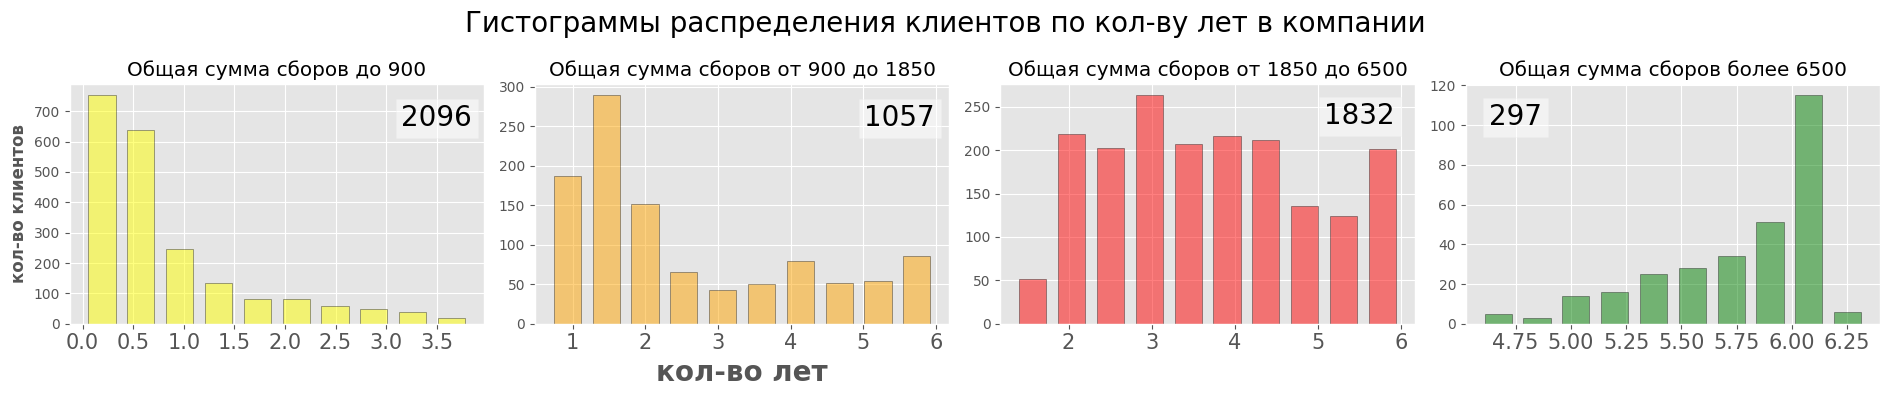

In [722]:
plt.figure(figsize=(19, 4))

ax = plt.subplot(1, 4, 1)
y = data.query('TotalCharges<=900').duration/365
ax.hist(
    y,
    edgecolor="black",
    color='yellow',
    alpha=.5,
    rwidth=0.7
)
plt.xticks(size=15)
summa = len(data.query('TotalCharges<=900'))
plt.text(
    3.5, 650,
    summa,
    ha='center',
    bbox=dict(facecolor='white', alpha=.5),
    size=20
)
plt.ylabel('кол-во клиентов')
ax.set_title("Общая сумма сборов до 900")
ax = plt.subplot(1, 4, 2)
ax.hist(
    data.query('900<=TotalCharges<=1850').duration/365,
    edgecolor="black",
    color='orange',
    alpha=.5,
    rwidth=0.7
)
plt.xticks(size=15)
summa = len(data.query('900<=TotalCharges<=1850'))
plt.text(
    5.5, 250,
    summa,
    ha='center',
    bbox=dict(
        facecolor='white',
        alpha=.5),
    size=20
)
plt.xlabel('кол-во лет', fontsize=20)
ax.set_title("Общая сумма сборов от 900 до 1850")
ax = plt.subplot(1, 4, 3)
ax.hist(
    data.query('1850<=TotalCharges<=6500').duration/365,
    edgecolor="black",
    color='red',
    alpha=.5,
    rwidth=0.7)
plt.xticks(size=15)
summa = len(data.query('1850<=TotalCharges<=6500'))
plt.text(
    5.5, 230,
    summa,
    ha='center',
    bbox=dict(
        facecolor='white',
        alpha=.5),
    size=20
)
ax.set_title("Общая сумма сборов от 1850 до 6500")
ax = plt.subplot(1, 4, 4)
ax.hist(
    data.query('6500<=TotalCharges').duration/365,
    edgecolor="black",
    color='green',
    alpha=.5,
    rwidth=0.7)
plt.xticks(size=15)
summa = len(data.query('6500<=TotalCharges'))
plt.text(
    4.75, 100,
    summa,
    ha='center',
    bbox=dict(
        facecolor='white',
        alpha=.5),
    size=20
)
ax.set_title("Общая сумма сборов более 6500")
plt.suptitle(
    'Гистограммы распределения клиентов по кол-ву лет в компании',
    fontsize=20
)
plt.tight_layout()

plt.show()


В основном уходят клиенты, которые были с компанией от 2 до 5 лет. Новые клиенты и те, что с компанией более 5 лет уходят гораздо меньше 

### Исследуем корреляцию целевого признака с суммами ежемесячных платежей клиента (по всем клиентам)

**Разобьем данные в столбце MonthlyCharges на 10 категорий и изучим распределение целевого признака в каждой из них.**

In [723]:
target_MonthlyCharges = data[
    [
        'target',
        'MonthlyCharges'
    ]
].hist2d(
    interval_cols=['MonthlyCharges'],
    bins={'MonthlyCharges': 10}
).reset_index(drop=True)

target_MonthlyCharges

MonthlyCharges,1,2,3,4,5,6,7,8,9,10
0,1065,127,257,413,311,582,601,524,414,162
1,110,13,27,57,46,87,127,130,161,68


In [724]:
hist, bin_edges = np.histogram(data.MonthlyCharges)
bin_edges

array([ 18.4  ,  28.435,  38.47 ,  48.505,  58.54 ,  68.575,  78.61 ,
        88.645,  98.68 , 108.715, 118.75 ])

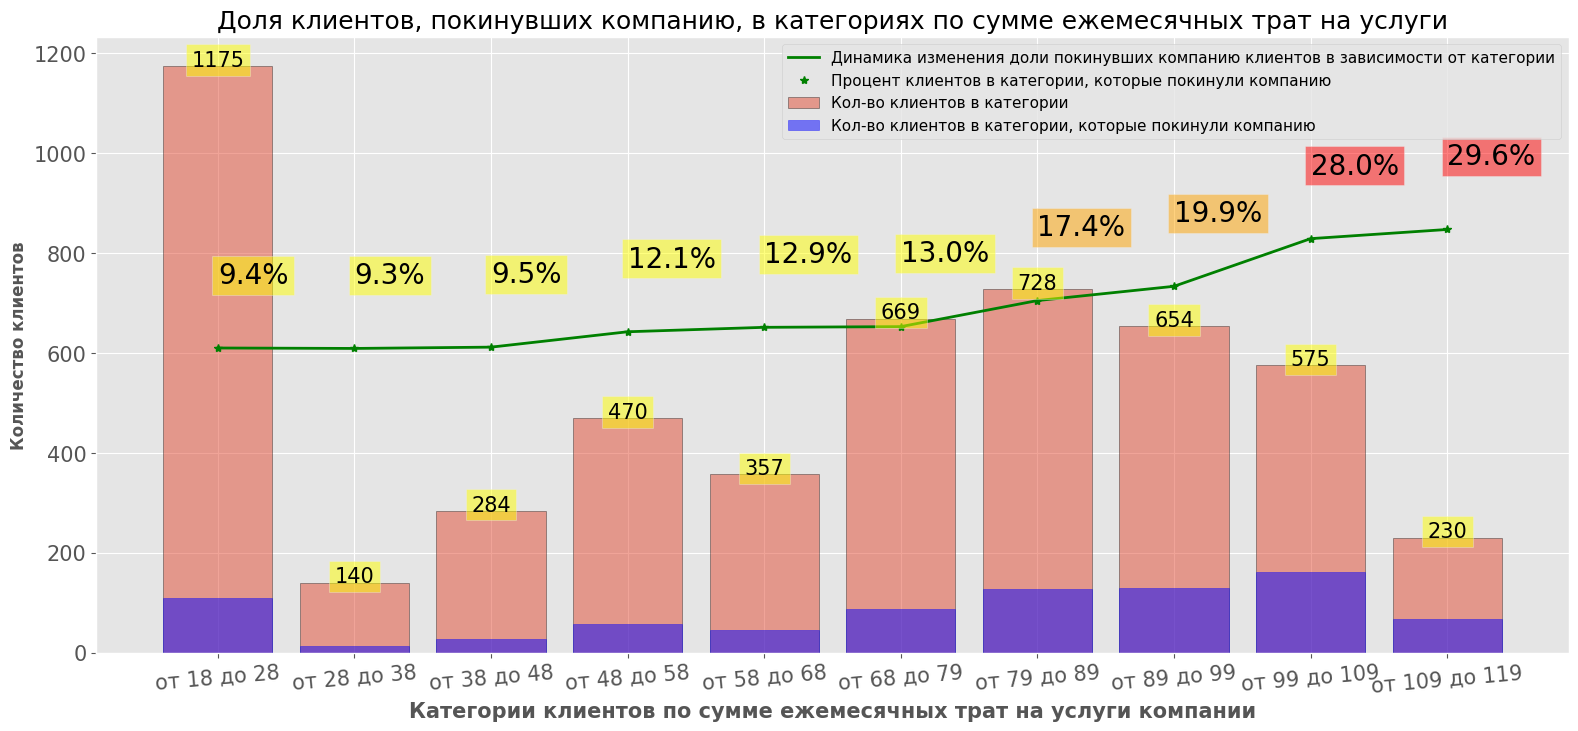

In [725]:
target_MonthlyCharges_chart = MultiFeaturesChart()

x = [
    'от 18 до 28',
    'от 28 до 38', 'от 38 до 48',
    'от 48 до 58', 'от 58 до 68',
    'от 68 до 79', 'от 79 до 89',
    'от 89 до 99', 'от 99 до 109',
    'от 109 до 119'
]
title = 'Доля клиентов, покинувших компанию, в категориях по сумме ежемесячных трат на услуги'
ylabel = 'Количество клиентов'
xlabel = 'Категории клиентов по сумме ежемесячных трат на услуги компании'
legend = [
    'Динамика изменения доли покинувших компанию клиентов в зависимости от категории',
    'Процент клиентов в категории, которые покинули компанию',
    'Кол-во клиентов в категории',
    'Кол-во клиентов в категории, которые покинули компанию'
]

target_MonthlyCharges_chart.config(
    x=x,
    df=target_MonthlyCharges,
    height_points=630,
    line_height=500,
    title=title,
    ylabel=ylabel,
    xlabel=xlabel,
    legend=legend,
    xticks_rotation=5
)

target_MonthlyCharges_chart.show()

На графике видно, что доля клиентов покинувших компанию, находится в районе 10-11% в категориях, где сумма ежемесячных платежей не превышает 79 у.е.\
В категориях, где сумма ежемесячных платежей превышает 79 долларов этот показатель возрастает с увеличением суммы.  


Постараемся выяснить, какие услуги настолько увеличивают размер ежемесячных платежей.\
Исследуем те же критерии для клиентов, пользующихся только услугой телефонии, без интернета.

### Исследуем корреляцию признаков по клиентам, использующим только услуги телефонии.

#### Построем тепловую карту корреляции (без интернета)

 Клиенты которые не пользуются интернетом:
Кол-во: 1113
Процент от общего количества клиентов: 21.1%


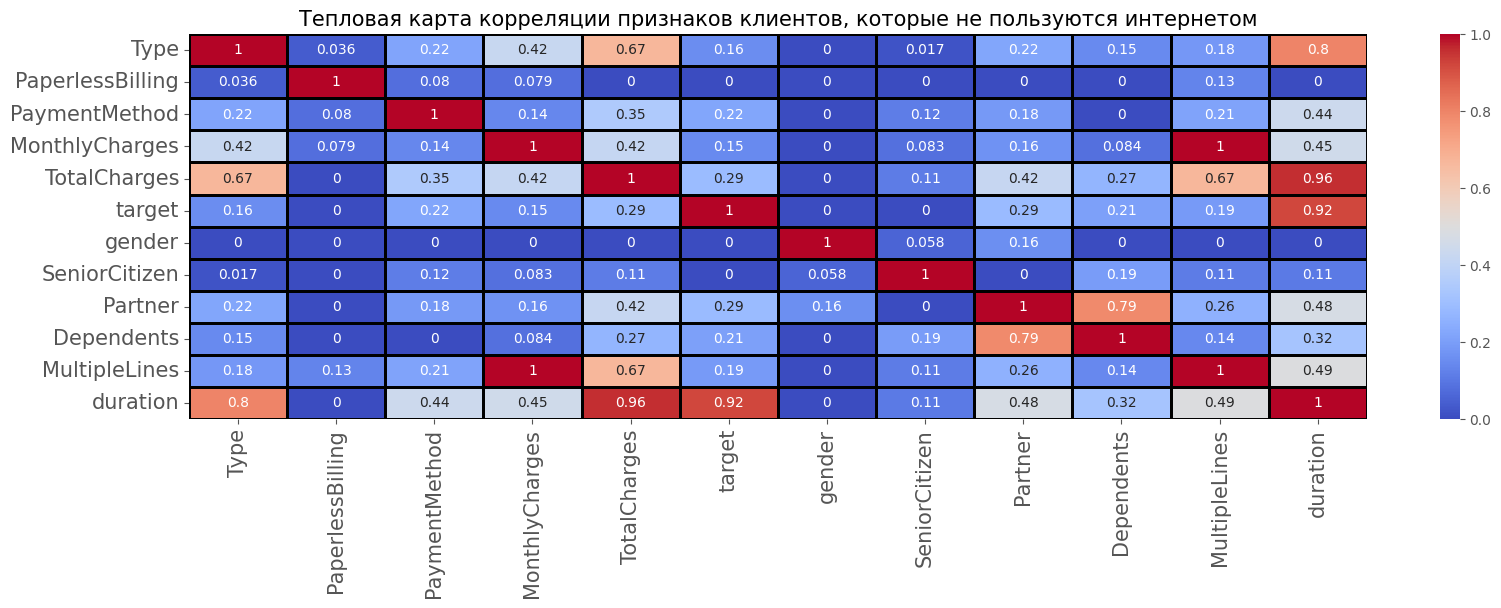

In [726]:
plt.figure(figsize=(19, 5))

sns.heatmap(
    (data
     .query('InternetService=="unknown"')
     .phik_matrix(
         interval_cols=[
             'MonthlyCharges',
             'TotalCharges'
         ]
     )),
    annot=True,
    linewidths=2,
    linecolor='black',
    cmap='coolwarm'
)

plt.title('Тепловая карта корреляции признаков клиентов, которые не пользуются интернетом', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
print('\033[1m', 'Клиенты которые не пользуются интернетом:' + '\033[0m')
print('='*20)
print('Кол-во:', len(data.query('InternetService=="unknown"')))
print('Процент от общего количества клиентов:',
      "{:.1%}".format(len(data.query('InternetService=="unknown"'))/len(data)))
print('='*20)

plt.show();

#### Исследуем корреляцию целевого признака с общими суммами трат клиента (без интернета)

In [727]:
target_TotalCharges_nointernet = data.query(
    'InternetService == "unknown"'
)[
    [
        'target',
        'TotalCharges'
    ]
].hist2d(
    interval_cols=['TotalCharges'],
    bins={'TotalCharges': 5}
).reset_index(drop=True)

target_TotalCharges_nointernet

TotalCharges,1,2,3,4,5
0,461,211,143,119,71
1,23,38,35,11,1


In [728]:
hist, bin_edges = np.histogram(
    data.query(
        'InternetService=="unknown"'
    ).TotalCharges,
    bins=5
)
np.round(bin_edges)

array([   0.,  388.,  775., 1163., 1551., 1939.])

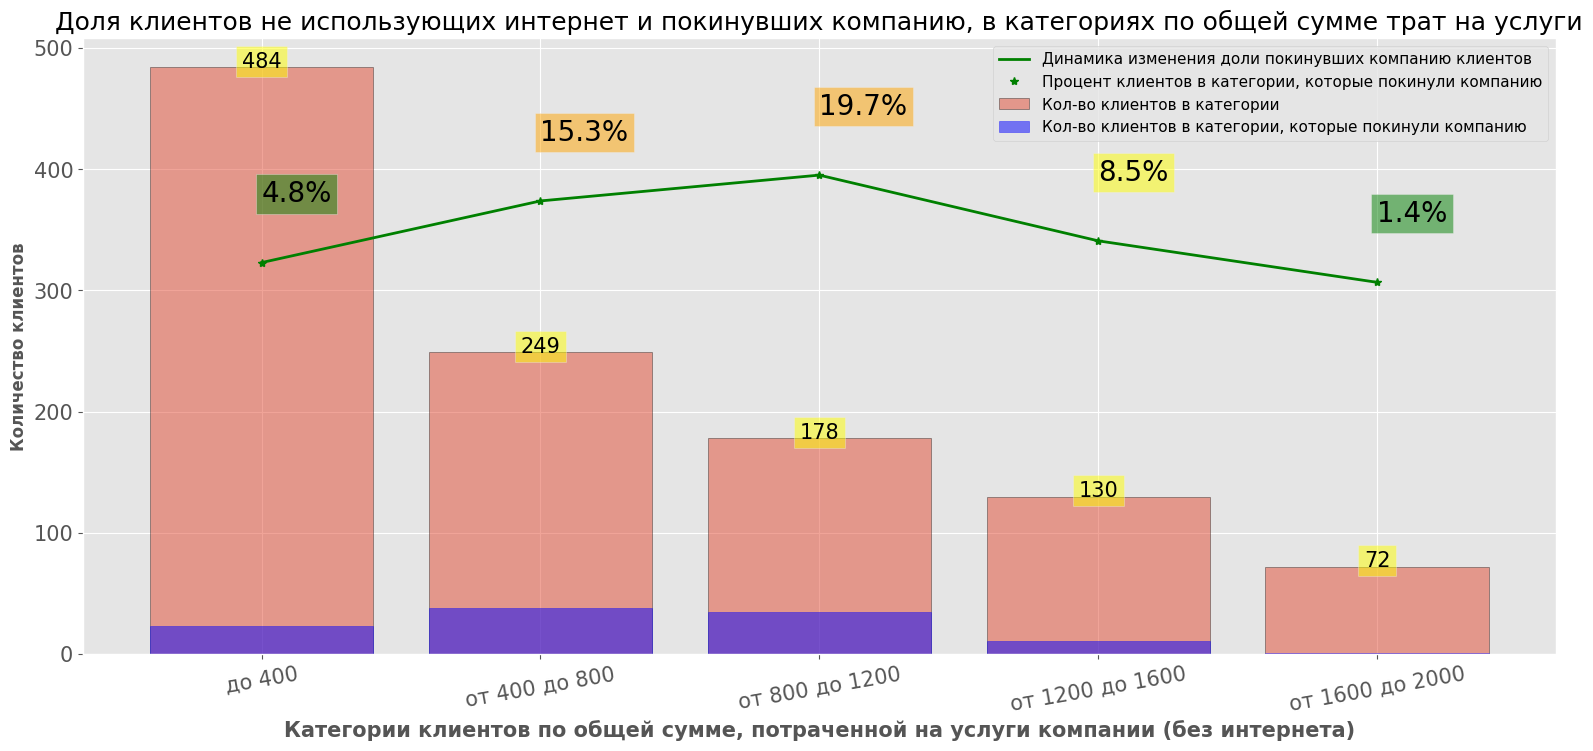

In [729]:
target_TotalCharges_nointernet_chart = MultiFeaturesChart()

x = [
    'до 400',
    'от 400 до 800',
    'от 800 до 1200',
    'от 1200 до 1600',
    'от 1600 до 2000'
]
title = 'Доля клиентов не использующих интернет и покинувших компанию, \
в категориях по общей сумме трат на услуги'
ylabel = 'Количество клиентов'
xlabel = 'Категории клиентов по общей сумме, потраченной на услуги компании (без интернета)'
legend = [
    'Динамика изменения доли покинувших компанию клиентов',
    'Процент клиентов в категории, которые покинули компанию',
    'Кол-во клиентов в категории',
    'Кол-во клиентов в категории, которые покинули компанию'
]

target_TotalCharges_nointernet_chart.config(
    x=x,
    df=target_TotalCharges_nointernet,
    height_points=350,
    line_height=300,
    title=title,
    ylabel=ylabel,
    xlabel=xlabel,
    legend=legend,
    xticks_rotation=10
)
target_TotalCharges_nointernet_chart.show()

#### Исследуем корреляцию целевого признака с суммами ежемесячных платежей клиента (без интернета)

In [730]:
target_MonthlyCharges_noint = data.query(
    'InternetService=="unknown"'
)[
    ['target', 'MonthlyCharges']
].hist2d(
    interval_cols=['MonthlyCharges'],
    bins={'MonthlyCharges': 2}
).reset_index(drop=True)

target_MonthlyCharges_noint

MonthlyCharges,1,2
0,812,193
1,68,40


In [731]:
hist, bin_edges = np.histogram(data.query('InternetService=="unknown"').MonthlyCharges, bins=2)
np.round(bin_edges,1)

array([18.4, 22.6, 26.8])

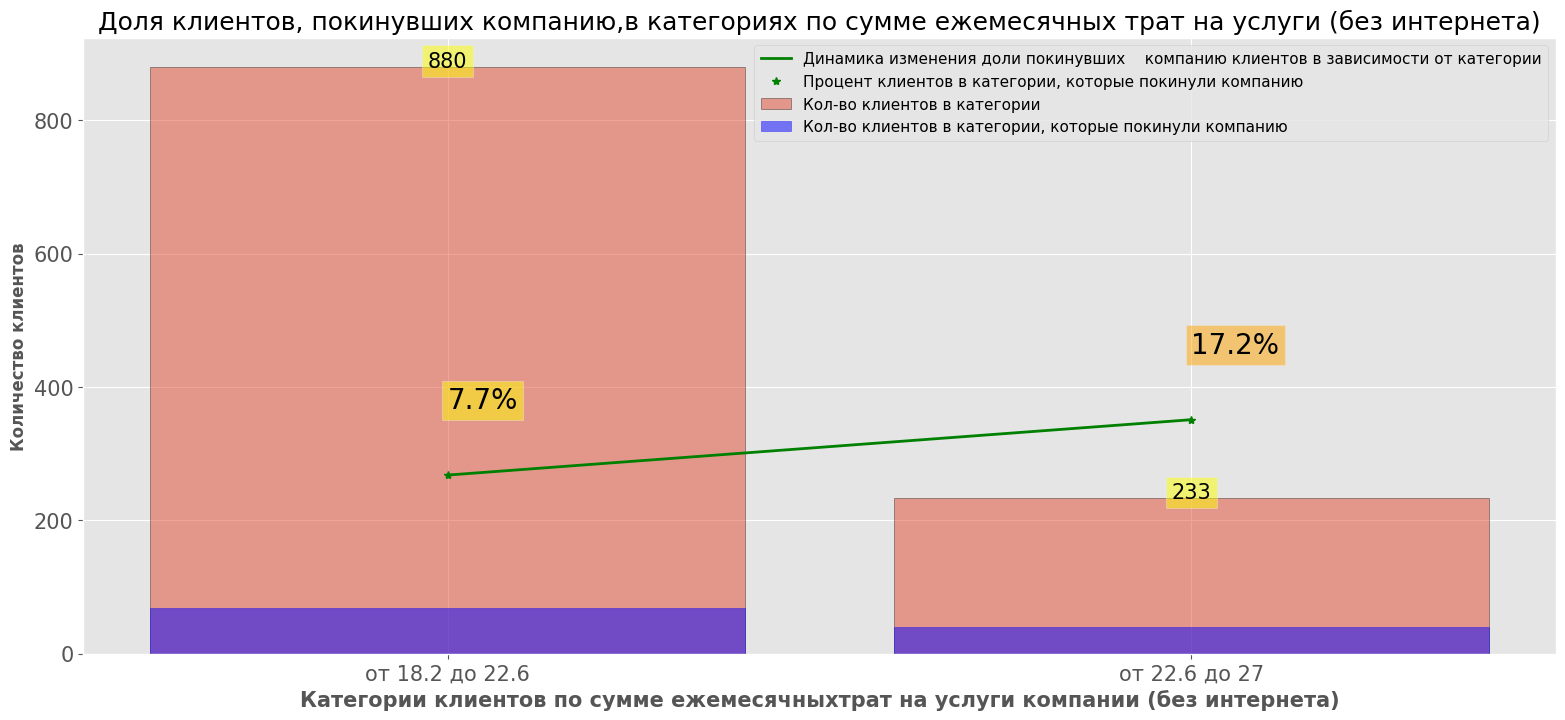

In [732]:
target_MonthlyCharges_noint_chart = MultiFeaturesChart()

x = [
    'от 18.2 до 22.6',
    'от 22.6 до 27'
]
title = 'Доля клиентов, покинувших компанию,\
в категориях по сумме ежемесячных трат на услуги (без интернета)'
ylabel = 'Количество клиентов'
xlabel = 'Категории клиентов по сумме ежемесячных\
трат на услуги компании (без интернета)'
legend = [
    'Динамика изменения доли покинувших\
    компанию клиентов в зависимости от категории',
    'Процент клиентов в категории, которые покинули компанию',
    'Кол-во клиентов в категории',
    'Кол-во клиентов в категории, которые покинули компанию'
]

target_MonthlyCharges_noint_chart.config(
    x=x,
    df=target_MonthlyCharges_noint,
    height_points=300,
    line_height=200,
    title=title,
    ylabel=ylabel,
    xlabel=xlabel,
    legend=legend,
    xticks_rotation=0
)

target_MonthlyCharges_noint_chart.show()

Аналогично общей картине, среди клиентов, пользующихся исключительно услугами телефонии, с увеличением стоимости услуг повышается доля покинувших компанию клиентов. 

На тепловой карте корреляции видно, что общая сумма сборов сильно связана с наличием услуги MultipleLines и типом договора. Наличие услуги MultipleLines также имеет линейную связь связь с размером ежемесячных платежей.
Использование услуги MultipleLines повышает размер ежемесячных платежей, что судя по графику выше, влияет на желание клиента покинуть компанию.\
Посмотрим, как на целевой признак исследуемой категории срок, на который заключён договор: месяц, год или два года.

#### Исследуем корреляцию целевого признака со сроком, на который заключен договор (без интернета)

In [733]:
target_Type_noint = data.query(
    'InternetService=="unknown"'
)[
    ['target', 'Type']
].hist2d(
    interval_cols=[]
).reset_index(drop=True)

target_Type_noint

Type,Month-to-month,One year,Two year
0,400,239,366
1,3,23,82


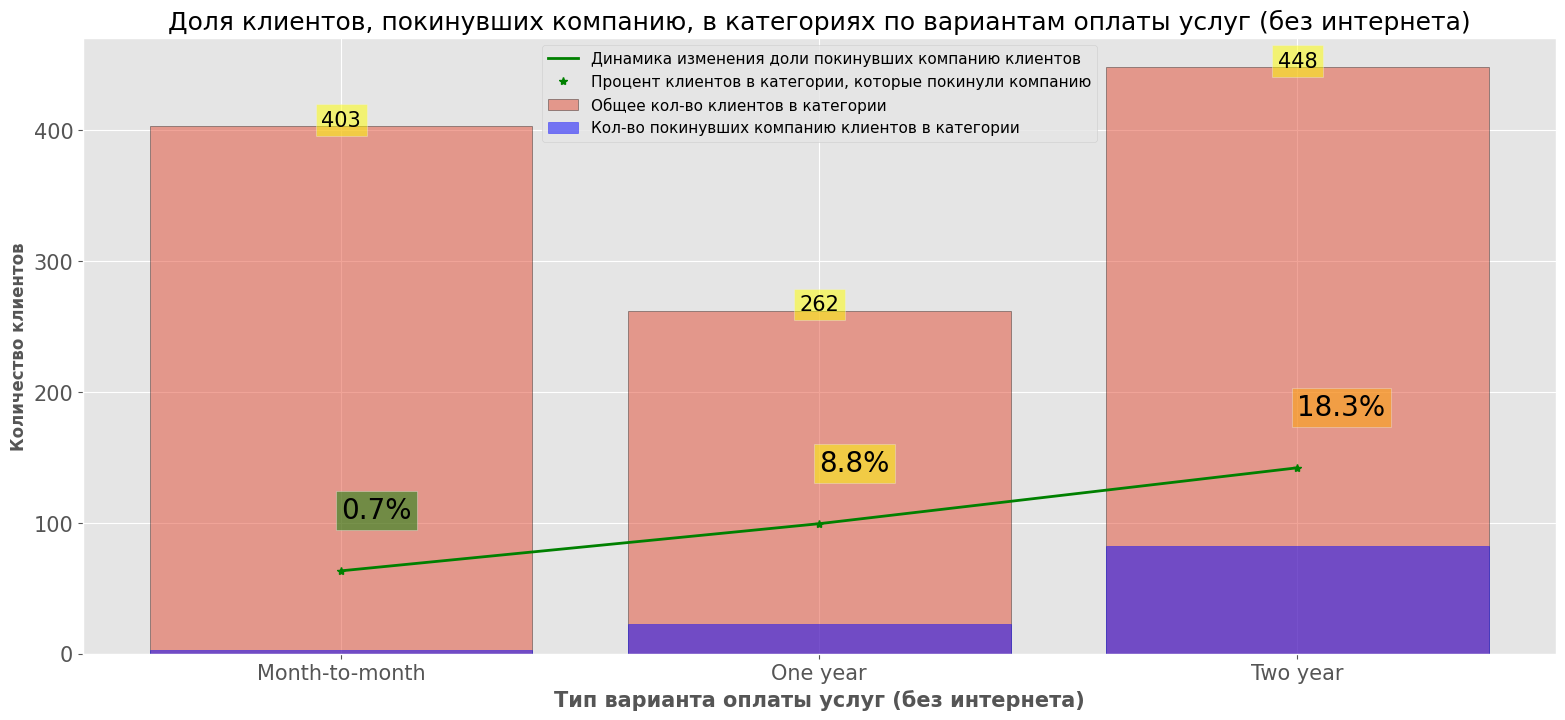

In [734]:
target_Type_noint_chart = MultiFeaturesChart()


title = 'Доля клиентов, покинувших компанию, в категориях по \
вариантам оплаты услуг (без интернета)'
ylabel = 'Количество клиентов'
xlabel = 'Тип варианта оплаты услуг (без интернета)'
legend = [
    'Динамика изменения доли покинувших компанию клиентов',
    'Процент клиентов в категории, которые покинули компанию',
    'Общее кол-во клиентов в категории',
    'Кол-во покинувших компанию клиентов в категории'
]

target_Type_noint_chart.config(
    df=target_Type_noint,
    height_points=100,
    line_height=60,
    title=title,
    ylabel=ylabel,
    xlabel=xlabel,
    legend=legend,
    xticks_rotation=0
)

target_Type_noint_chart.show()

На графике видно, что клиентов абсолютно все устраивает, если они пользуються только услугами телефонии и оплачивают их каждый месяц. Возможно стоит пересмотреть условия договоров на длительный период.

### Исследуем категорию клиентов, которые пользуются только интернет услугами

#### Построем тепловую карту корреляции (без телефонии)

 Кол-во клиентов, которые не пользуются телефонией:
506
Процент от общего количества клиентов: 9.6%


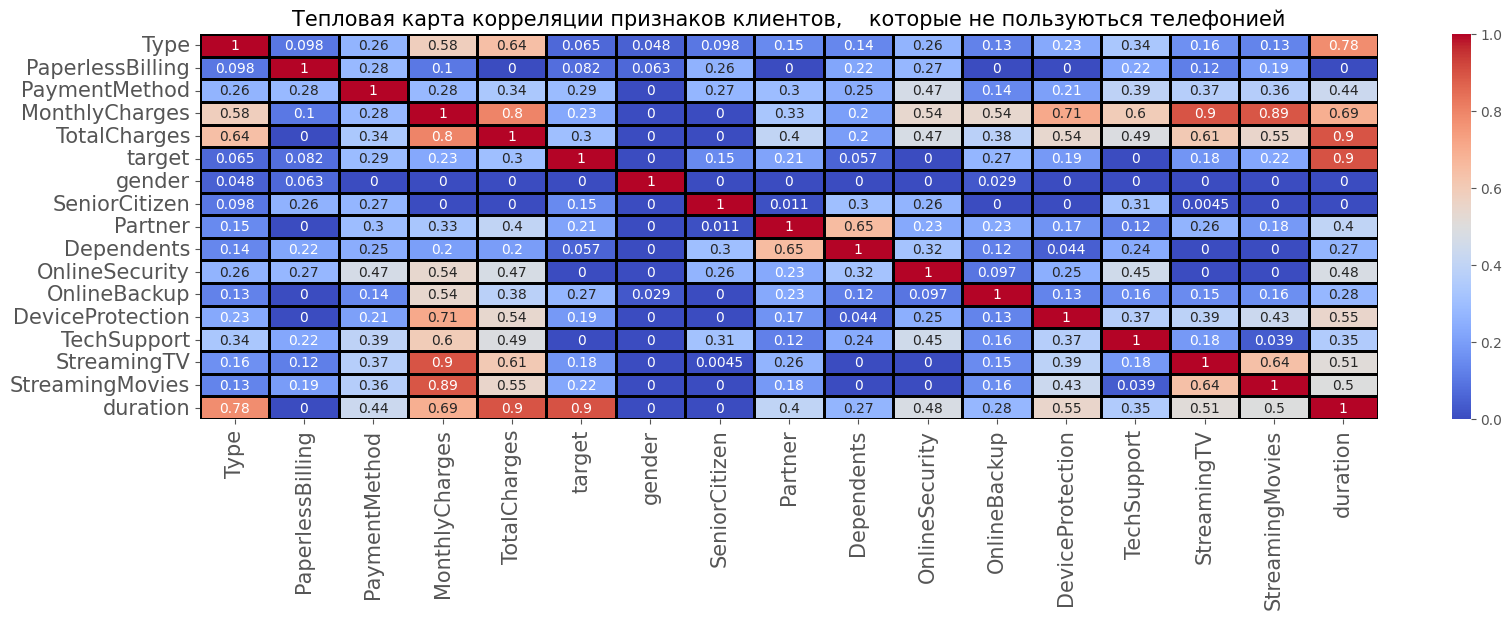

In [735]:
plt.figure(figsize= (19,5))

sns.heatmap(
    data.query(
        'MultipleLines=="unknown"'
    ).phik_matrix(
        interval_cols=['MonthlyCharges', 'TotalCharges']
    ),
    annot=True,
    linewidths=2,
    linecolor='black',
    cmap='coolwarm'
)

plt.title(
    'Тепловая карта корреляции признаков клиентов,\
    которые не пользуються телефонией',
    size=15
)
plt.xticks(size=15)
plt.yticks(size=15)
print('\033[1m',
      'Кол-во клиентов, которые не пользуются телефонией:' + '\033[0m')
print('='*20)
print(len(data.query('MultipleLines=="unknown"')))
print('Процент от общего количества клиентов:',
      "{:.1%}".format(len(data.query('MultipleLines=="unknown"'))/len(data)))
print('='*20)


plt.show();

Из тепловой, карты помимо MultipleLines, исчез признак InternetService.

In [736]:
data.query('MultipleLines=="unknown"').InternetService.unique()

array(['DSL'], dtype=object)

Клиенты, пользуются только DSL типом подключения. Так же видно, что исчезла мультиколлинеарность в блоке признаков с интернет услугами. 

На первое место по значению корреляции с целевым признаком, помимо TotalCharges, попал признак с методом оплаты.

#### Исследуем корреляцию целевого признака с общими суммами трат клиента (без телефонии)

In [737]:
target_TotalCharges_notell = data.query(
    'MultipleLines=="unknown"'
)[
    ['target', 'TotalCharges']
].hist2d(
    interval_cols=['TotalCharges'],
    bins={'TotalCharges': 5}
).reset_index(drop=True)

target_TotalCharges_notell

TotalCharges,1,2,3,4,5
0,223.0,87.0,61.0,36.0,24.0
1,27.0,29.0,16.0,3.0,0.0


In [738]:
hist, bin_edges = np.histogram(data.query('MultipleLines=="unknown"').TotalCharges, bins=5)
np.round(bin_edges)

array([   0., 1026., 2053., 3079., 4106., 5132.])

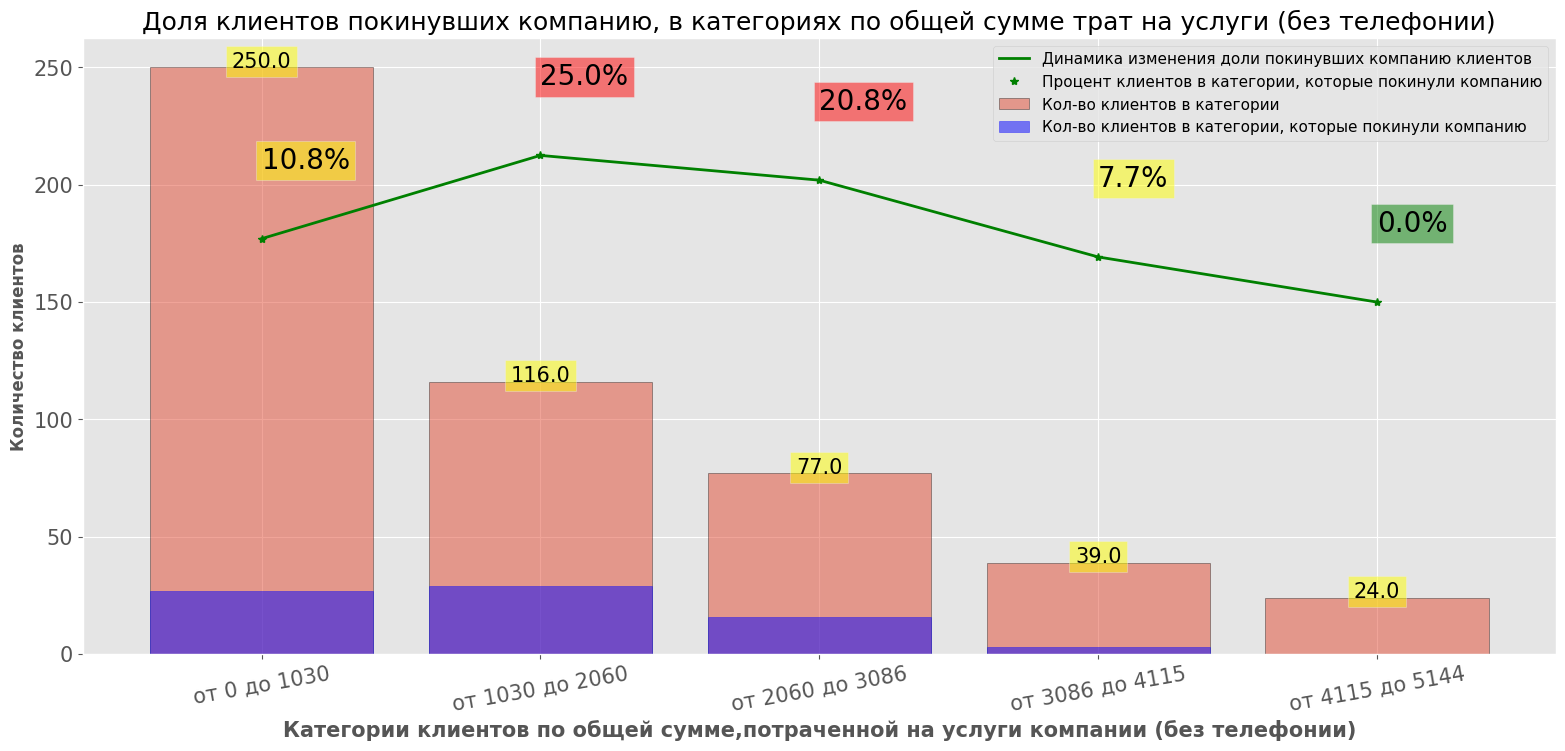

In [739]:
target_TotalCharges_notell_chart = MultiFeaturesChart()

x = [
    'от 0 до 1030',
    'от 1030 до 2060',
    'от 2060 до 3086',
    'от 3086 до 4115',
    'от 4115 до 5144'
]
title = 'Доля клиентов покинувших компанию, \
в категориях по общей сумме трат на услуги (без телефонии)'
ylabel = 'Количество клиентов'
xlabel = 'Категории клиентов по общей сумме,\
потраченной на услуги компании (без телефонии)'
legend = [
    'Динамика изменения доли покинувших компанию клиентов',
    'Процент клиентов в категории, которые покинули компанию',
    'Кол-во клиентов в категории',
    'Кол-во клиентов в категории, которые покинули компанию'
]

target_TotalCharges_nointernet_chart.config(
    x=x,
    df=target_TotalCharges_notell,
    height_points=180,
    line_height=150,
    title=title,
    ylabel=ylabel,
    xlabel=xlabel,
    legend=legend,
    xticks_rotation=10
)

target_TotalCharges_nointernet_chart.show()

#### Исследуем корреляцию целевого признака с вариантами методов оплаты (без телефонии)

In [740]:
target_PaymentMethod_notell = data.query(
    'MultipleLines=="unknown"'
)[
    ['target', 'PaymentMethod']
].hist2d(
    interval_cols=[]
).reset_index(drop=True)

target_PaymentMethod_notell

PaymentMethod,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
0,75,100,145,111
1,29,16,23,7


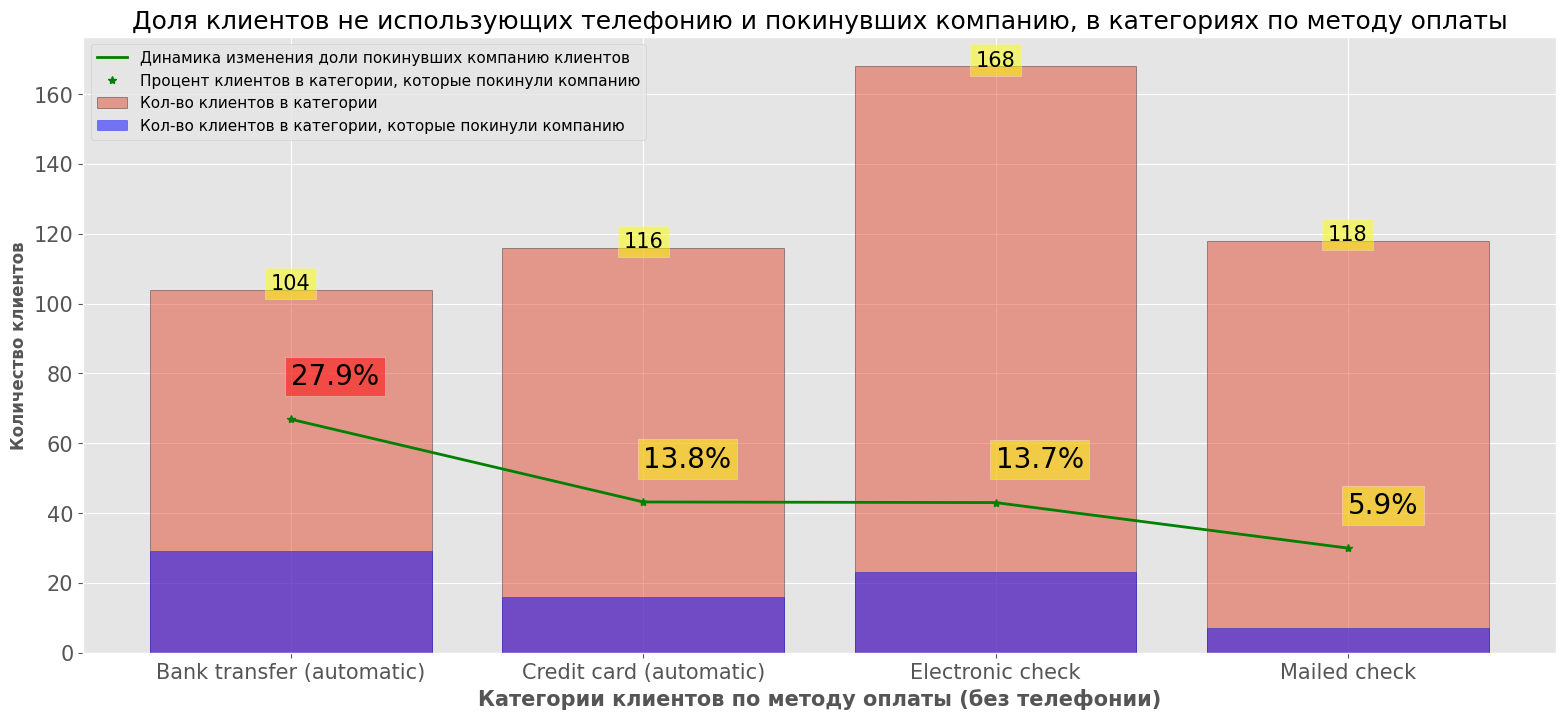

In [741]:
target_PaymentMethod_notell_chart = MultiFeaturesChart()

x = [
    'от 0 до 1030',
    'от 1030 до 2060',
    'от 2060 до 3086',
    'от 3086 до 4115',
    'от 4115 до 5144'
]
title = 'Доля клиентов не использующих телефонию и покинувших компанию, \
в категориях по методу оплаты'
ylabel = 'Количество клиентов'
xlabel = 'Категории клиентов по методу оплаты (без телефонии)'
legend = [
    'Динамика изменения доли покинувших компанию клиентов',
    'Процент клиентов в категории, которые покинули компанию',
    'Кол-во клиентов в категории',
    'Кол-во клиентов в категории, которые покинули компанию'
]

target_PaymentMethod_notell_chart.config(
    df=target_PaymentMethod_notell,
    height_points=30,
    line_height=20,
    title=title,
    ylabel=ylabel,
    xlabel=xlabel,
    legend=legend,
    xticks_rotation=0
)

target_PaymentMethod_notell_chart.show()

#### Исследуем корреляцию целевого признака со сроком, на который заключен договор (без телефонии)

In [742]:
target_Type_notell = data.query(
    'MultipleLines=="unknown"'
)[
    ['target', 'Type']
].hist2d(
    interval_cols=[]
).reset_index(drop=True)

target_Type_notell

Type,Month-to-month,One year,Two year
0,253,80,98
1,31,20,24


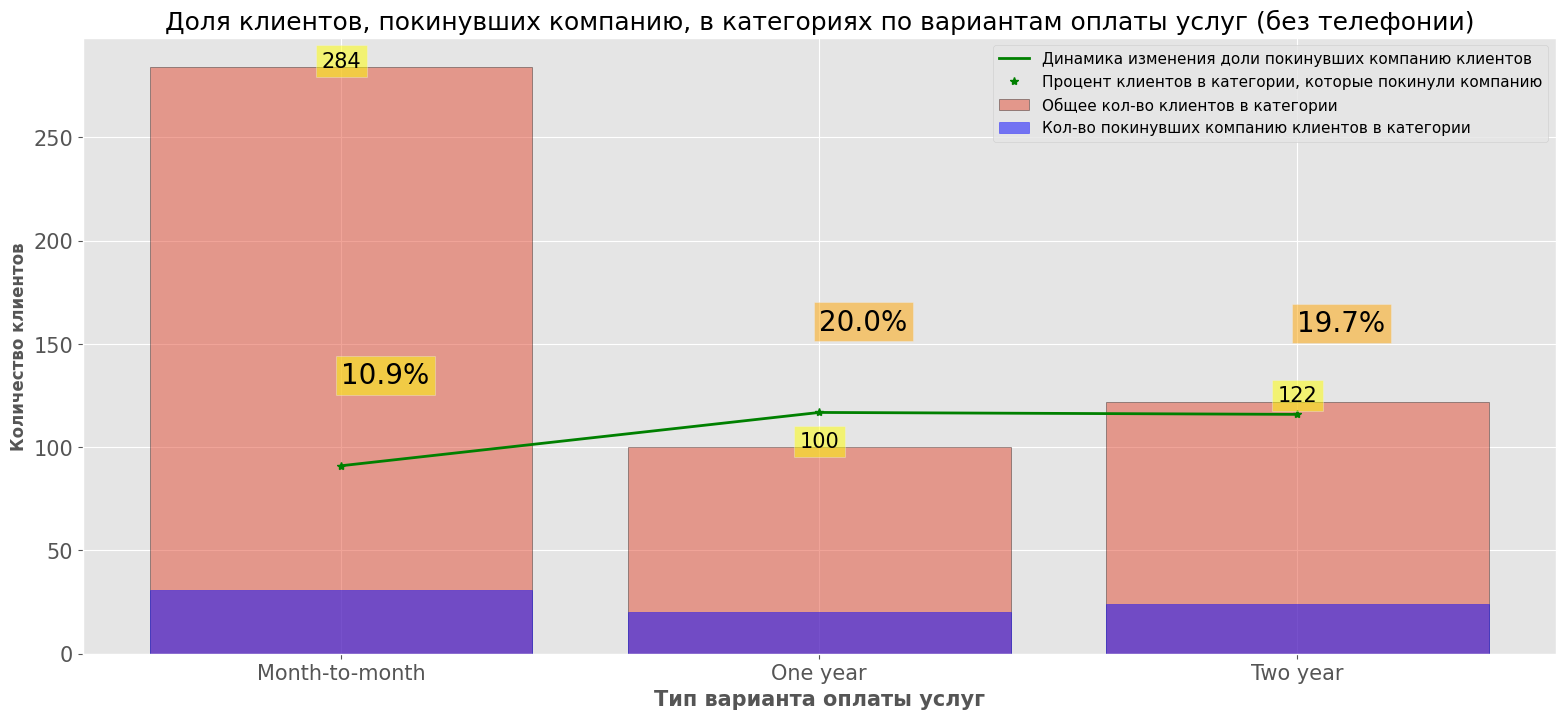

In [743]:
target_Type_notell_chart = MultiFeaturesChart()


title = 'Доля клиентов, покинувших компанию, в категориях по \
вариантам оплаты услуг (без телефонии)'
ylabel = 'Количество клиентов'
xlabel = 'Тип варианта оплаты услуг'
legend = [
    'Динамика изменения доли покинувших компанию клиентов',
    'Процент клиентов в категории, которые покинули компанию',
    'Общее кол-во клиентов в категории',
    'Кол-во покинувших компанию клиентов в категории'
]

target_Type_noint_chart.config(
    df=target_Type_notell,
    height_points=100,
    line_height=60,
    title=title,
    ylabel=ylabel,
    xlabel=xlabel,
    legend=legend,
    xticks_rotation=0
)

target_Type_noint_chart.show()

Распределение целевого признака по категориям TotalCharges примерно такое же, что мы видели ранее. Клиенты покидают компанию не сразу.\
Это подтверждается тем, что клиенты этой категории использующие тип оплаты раз в год и раз в два года уходят в два раза чаще, чем те, что платят раз в месяц.\
Так же видно, что есть проблемы с электронными и автоматическими типами оплаты. Так как это не относится непосредственно к определенной услуге, то имеет смысл посмотреть на эту проблему в масштабе всей компании.

### Исследуем корреляцию целевого признака с вариантами методов оплаты (по всем клиентам)

In [744]:
target_PaymentMethod = data[
    ['target', 'PaymentMethod']
].hist2d(
    interval_cols=[]
).reset_index(drop=True)

target_PaymentMethod

PaymentMethod,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
0,941,897,1502,1116
1,241,228,269,88


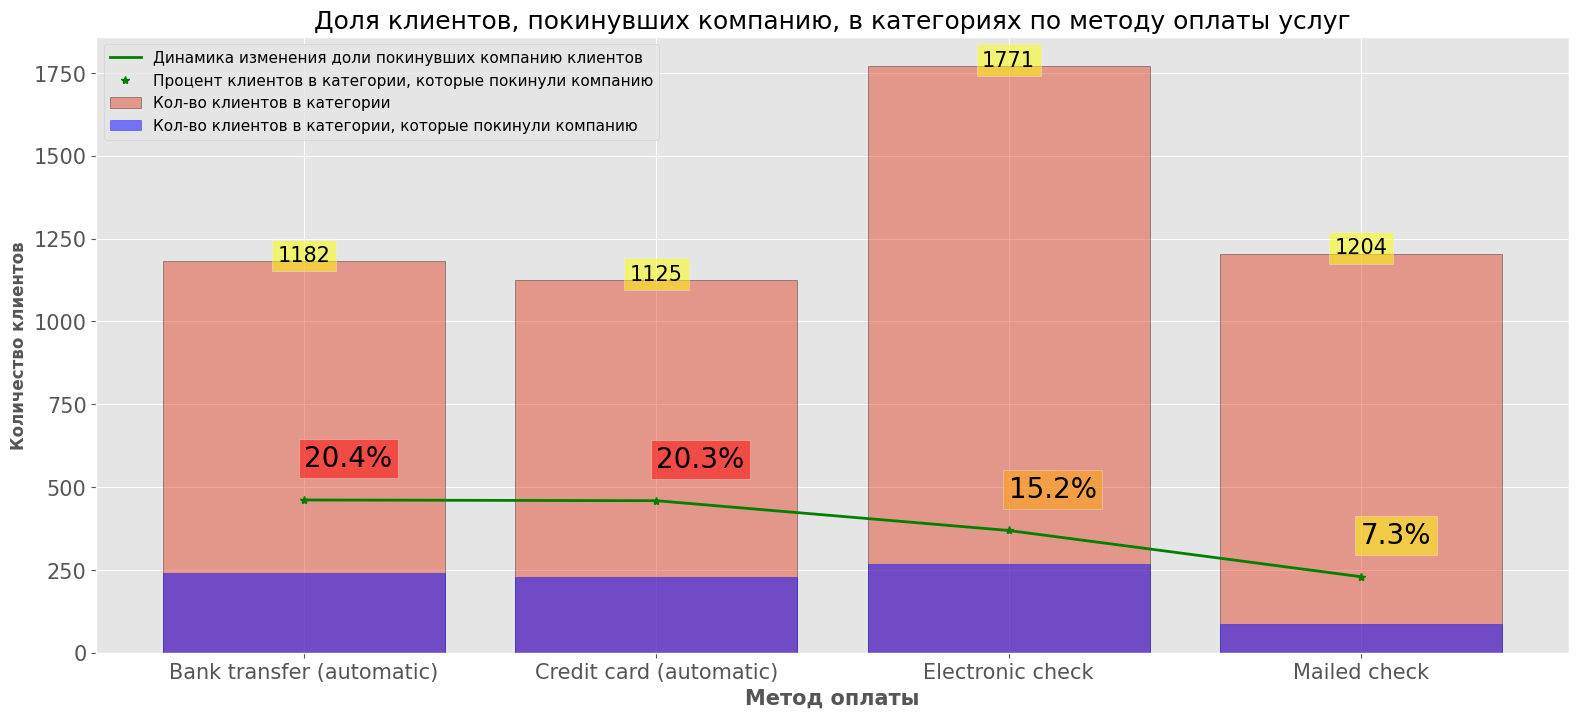

In [745]:
target_PaymentMethod_chart = MultiFeaturesChart()


title = 'Доля клиентов, покинувших компанию, в категориях по методу оплаты услуг'
ylabel = 'Количество клиентов'
xlabel = 'Метод оплаты'
legend = [
    'Динамика изменения доли покинувших компанию клиентов',
    'Процент клиентов в категории, которые покинули компанию',
    'Кол-во клиентов в категории',
    'Кол-во клиентов в категории, которые покинули компанию'
]

target_PaymentMethod_chart.config(
    df=target_PaymentMethod,
    height_points=200,
    line_height=100,
    title=title,
    ylabel=ylabel,
    xlabel=xlabel,
    legend=legend,
    xticks_rotation=0
)

target_PaymentMethod_chart.show()

В разрезе всей компании проблема обозначилась более четко: клиенты, использующие автоматические методы оплаты, покидают компанию в три раза чаще, чем клиенты, которые платят наличкой. 

Относительно высокую корреляцию с целевым признаком в разрезе всей компании так же имеет столбец Partner, содержащий информацию состоит ли клиент в браке.

### Исследуем корреляцию целевого признака с тем, состоит ли клиент в браке (по всем клиентам)

In [746]:
target_Partner = data[
    ['target', 'Partner']
].hist2d(
    interval_cols=[]
).reset_index(
    drop=True
)
target_Partner

Partner,No,Yes
0,2428,2028
1,277,549


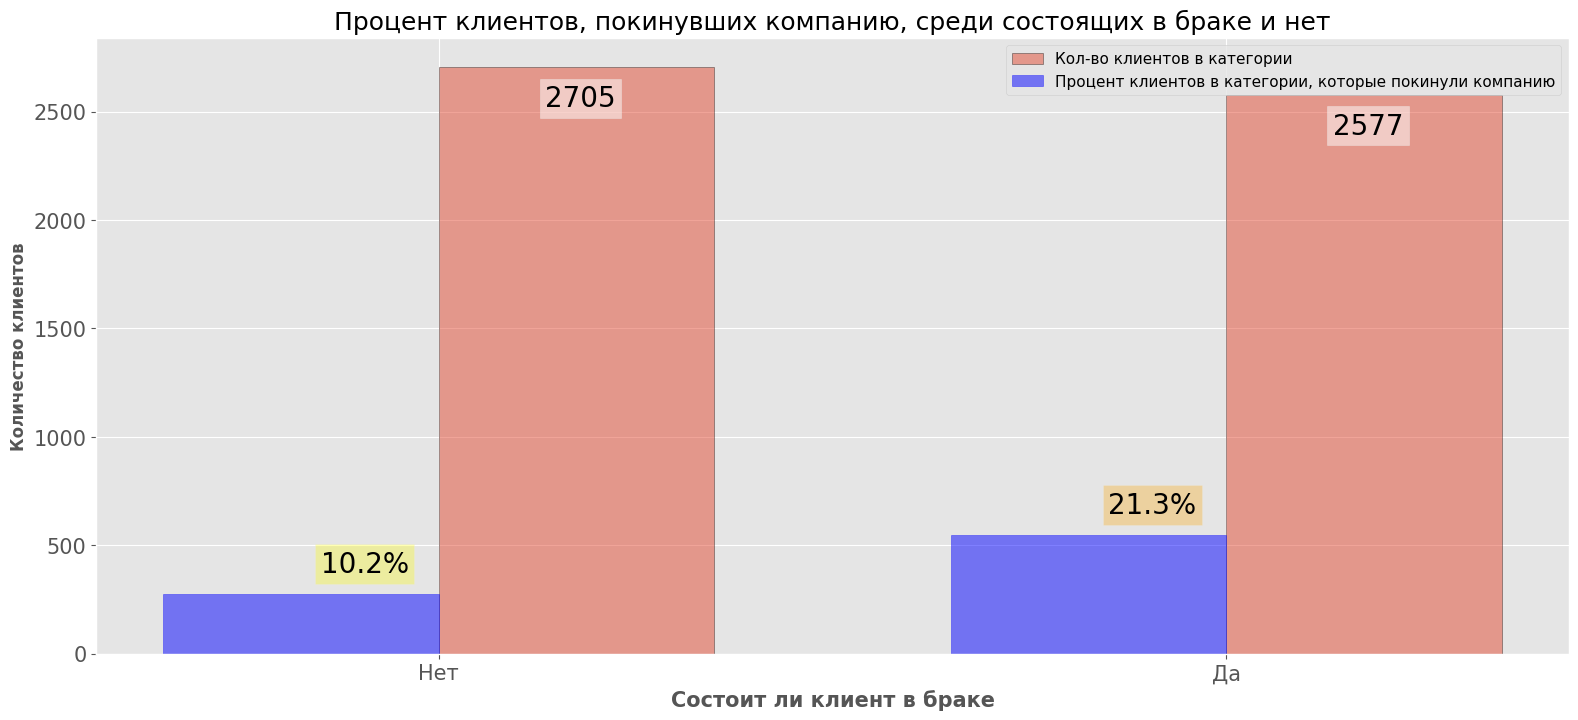

In [747]:
target_Partner_chart = TwoFeaturesChart()

x = ['Нет', 'Да']
title = 'Процент клиентов, покинувших компанию, среди состоящих в браке и нет'
ylabel = 'Количество клиентов'
xlabel = 'Состоит ли клиент в браке'
legend = [
    'Кол-во клиентов в категории',
    'Процент клиентов в категории, которые покинули компанию'
]

target_Partner_chart.config(
    x=x,
    df=target_Partner,
    title=title,
    ylabel=ylabel,
    xlabel=xlabel,
    legend=legend,
    xticks_rotation=0
)

target_Partner_chart.show()

Среди клиентов компании, которые состоят в браке, процент покинувших компанию в 2 раза выше, чем среди холостых. \
Высокой корреляции у этого признака с другими не наблюдается. Возможно причина в комплексе факторов и эта проблема следует из перечисленных выше.

### Вывод по исследовательскому анализу

Компания оказывает два основных типа услуг:

* Телефония
* Интернет

Наибольшая корреляция целевого признака с общей суммой трат клиента.

<img src="image-1.png" alt="image-1.png" width="600"/>

На графике видно, что среди клиентов, затративших на услуги компании от 1850 до 4600 большой процент покинувших компанию. Общая сумма складываеться из ежемесячных фиксированных оплат по тарифу плюс дополнительные траты на комиссии и т.п..

<img src="image-2.png" alt="image-2.png" />

В основном уходят клиенты, которые были с компанией от 2 до 5 лет. Новые клиенты и те, что с компанией более 5 лет уходят гораздо меньше.

<img src="image-3.png" alt="image-3.png" width="600"/>

На графике видно, что доля клиентов покинувших компанию, находится в районе 10-11% в категориях, где сумма ежемесячных платежей не превышает 79 у.е.
В категориях, где сумма ежемесячных платежей превышает 79 долларов этот показатель возрастает с увеличением суммы.

**Исследуем те же критерии для клиентов, пользующихся только услугой телефонии, без интернета.**

<img src="image-5.png" alt="image-5.png" width="600"/>


Аналогично общей картине, среди клиентов, пользующихся исключительно услугами телефонии, с увеличением стоимости услуг повышается доля покинувших компанию клиентов.

<img src="image-4.png" alt="image-4.png" />


Судя по тепловой карте корреляции общая сумма сборов сильно связана с наличием услуги MultipleLines и типом договора. Наличие услуги MultipleLines также имеет линейную связь связь с размером ежемесячных платежей. Использование услуги MultipleLines повышает размер ежемесячных платежей, что судя по графику выше, влияет на желание клиента покинуть компанию.
Посмотрим, как на целевой признак исследуемой категории влияет срок, на который заключён договор: месяц, год или два года.

<img src="image-6.png" alt="image-6.png" width="600"/>


На графике видно, что клиентов абсолютно все устраивает, если они пользуються только услугами телефонии и оплачивают их каждый месяц.

**Резюме:** Возможно стоит пересмотреть условия договоров на длительный период. И подробнее изучить, меняется ли стоимость MultipleLines в зависимости от того, на какой срок заключается договор.**

**Исследуем категорию клиентов, которые пользуются только интернет услугами.**

На первое место по значению корреляции с целевым признаком, помимо TotalCharges, попал признак с методом оплаты.

<img src="image-7.png" alt="image-7.png" width="600"/>

<img src="image-8.png" alt="image-8.png" width="600"/>

<img src="image-9.png" alt="image-9.png" width="600"/>


Распределение целевого признака по категориям TotalCharges примерно такое же, что мы видели ранее. Клиенты покидают компанию не сразу.
Это подтверждается тем, что клиенты этой категории использующие тип оплаты раз в год и раз в два года уходят в два раза чаще, чем те, что платят раз в месяц.
Так же видно, что есть проблемы с электронными и автоматическими типами оплаты. Так как это не относится непосредственно к определенной услуге, то имеет смысл посмотреть на эту проблему в масштабе всей компании.

<img src="image-10.png" alt="image-10.png" width="600"/>

В разрезе всей компании проблема обозначилась более четко: клиенты, использующие автоматические методы оплаты, покидают компанию в три раза чаще, чем клиенты, которые платят наличкой.

Относительно высокую корреляцию с целевым признаком в разрезе всей компании так же имеет столбец Partner, содержащий информацию состоит ли клиент в браке.

<img src="image-11.png" alt="image-11.png" width="600"/>

Среди клиентов компании, которые состоят в браке, процент покинувших компанию в 2 раза выше, чем среди холостых.
Высокой корреляции у этого признака с другими не наблюдается. Возможно причина в комплексе факторов и эта проблема следует из перечисленных выше.

**Итог**

Исследование позволило создать примерный портрет клиента, который возможно покинет компанию:
* Ежемесячный платеж от 79 долларов и выше
* Пользуется предоплатными типами договора (оплата раз в год или раз в два года)
* Пользуется автоматическими способами оплаты (Bank transfer или Credit card)

## Удаление неинформативных признаков

Посмотрим еще раз на тепловую карту корреляции

<img src="image-12.png" alt="image-12.png" width="800"/>

* Удаляем признак gender. Пол клиента вообще никак не связан ни с одной из категорий.
* Удаляем признак SeniorCitizen.У этого признака есть есть небольшая корреляция с методами оплаты услуг, это может быть причиной не совсем нулевой корреляции с целевым признаком. Но вряд ли говорит о том, что пожилые люди покидают компанию просто из-за своего возраста.
* Удаляем признак Dependents. У этого признака высокая корреляция с семейным положением, отсюда и ненулевая корреляция с целевым признаком. 
* Удаляем признак PaperlessBilling. Имеется или нет накладная на бумажном носителе мало влияет на целевой признак.
* Блок признаков с наличием тех или иных интеренет услуг и InternetService имеет высокую мультиколлинеарность. Из всех этих признаков оставим только OnlineBackup и StreamingMovies, так как у них самая высока корреляция с целевым признаком

Созданный нами признак duration имеет высокую корреляцию с таргетом. Это объясняется тем, что компания оказывает услуги по предоплате. Клиент не покидает компанию до окончания оплаченного периода: месяц, год, два года. Т.о., если у клиента договор на год, и с момента его заключения прошло всего несколько месяцев, вероятность того, что он покинет компанию в ближайшее время довольно низкая. Соответственно ближе к концу действия договора эта вероятность возрастает, если портрет клиента совпадает с описанным выше.

# Обучение моделей

In [748]:
def str_to_digit(X: pd.DataFrame, y=None):
    x_copy = X.copy()
    if is_string_dtype(x_copy['TotalCharges']):
        x_copy.TotalCharges = x_copy.TotalCharges.apply(
            lambda x: 0 if not is_number(x) else x
        )
        x_copy.TotalCharges = x_copy.TotalCharges.astype(float)
    
    if is_string_dtype(x_copy['MonthlyCharges']):
        x_copy.MonthlyCharges = x_copy.MonthlyCharges.apply(
            lambda x: 0 if not is_number(x) else x
        )
        x_copy.MonthlyCharges = x_copy.MonthlyCharges.astype(float)
    
    return x_copy

def craft_data_trans(X: pd.DataFrame, y=None):
    x_copy = X.copy()
    x_copy.loc[x_copy['EndDate'] == 'No', 'EndDate'] = TODAY
    x_copy['EndDate'] = pd.to_datetime(x_copy['EndDate'])
    x_copy['BeginDate'] = pd.to_datetime(x_copy['BeginDate'])
    
    x_copy['duration'] = (x_copy['EndDate'] - x_copy['BeginDate']).dt.days
    x_copy = x_copy.drop(columns=[
        'gender',
        'SeniorCitizen',
        'Dependents',
        'customerID',
        'BeginDate',
        'EndDate',
        'OnlineSecurity',
        'PaperlessBilling',
        'DeviceProtection',
        'TechSupport',
        'InternetService',
        'StreamingTV'
    ])
    
    return x_copy

In [749]:
X_train = initial_data.drop('target', axis=1)
y_train = initial_data['target']

## Определяем категориальные и дискретные признаки

In [750]:
cat_features = [
    'Type',    
    'PaymentMethod',
    'Partner',    
    'MultipleLines',
    'OnlineBackup',
    'StreamingMovies'
]

num_features = [
    'MonthlyCharges',
    'TotalCharges',
    'duration'
]

## Прописываем пайплайны с разными алгоритмами кодирования категориальных признаков и список с гиперпараметрами для перебора по сетке

In [751]:
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])

categorical_transformer_te = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('encoder', ce.TargetEncoder(handle_unknown='ignore'))
    ])

column_trans_ohe = make_column_transformer(
    (categorical_transformer, cat_features),
    (StandardScaler(), num_features),
    remainder='drop'
)

column_trans_te = make_column_transformer(
    (categorical_transformer_te, cat_features),
    (StandardScaler(), num_features),
    remainder='drop'
)


model_lr = LogisticRegression(
    random_state=RANDOM_STATE,
    class_weight='balanced'
)
model_rf = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight='balanced'
)
model_lgb = lgb.LGBMClassifier(
    random_state=RANDOM_STATE,
    metric='roc_auc',
    objective='binary',
    class_weight='balanced'
)




pipe = Pipeline(
    [
        ('str_to_digit', FunctionTransformer(str_to_digit)),
        ('add_duration', FunctionTransformer(craft_data_trans)),
        ('enc', column_trans_ohe),
        ('regressor', model_lr)
    ]
)



param_grid = [
    {
        'enc': [column_trans_ohe, column_trans_te],
        'regressor': [model_lr]
    },
    {
        'enc':[column_trans_ohe, column_trans_te],
        'regressor': [model_rf],
        'regressor__max_depth': range(2, 20, 2),
        'regressor__n_estimators': range(10, 100, 10)
    },
    {
        'enc': [column_trans_ohe, column_trans_te],
        'regressor': [model_lgb],
        'regressor__max_depth': range(2, 10, 2),
        'regressor__n_estimators': (20, 800, 20),
        'regressor__is_unbalance': [True, False],
        'regressor__learning_rate': [.1]
    }
]

## Подбираем гиперпараметры и обучаем модели

In [752]:
model_grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring=['roc_auc', 'accuracy'],
    refit='roc_auc',
    n_jobs=-1    
)

model_grid.fit(X_train, y_train)

print(model_grid.best_score_)

0.8869278066042566


In [753]:
model_grid.best_estimator_

Pipeline(steps=[('str_to_digit',
                 FunctionTransformer(func=<function str_to_digit at 0x000002B21F6F12D0>)),
                ('add_duration',
                 FunctionTransformer(func=<function craft_data_trans at 0x000002B21F6F1AB0>)),
                ('enc',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   TargetEncode...e_unknown='ignore'))]),
                                                  ['Type', 'PaymentMethod',
                                                   'Partner', 'MultipleLines',
                                                   'OnlineBackup',
                                                   'StreamingMovies']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'duration'])])),
                ('regressor',
                 LGBMClassifier(class_weight='balanced', is_unbalance=False,
                                max_depth=2, metric='roc_auc', n_estimators=800,
                                objective='binary', random_state=50623))])

In [754]:
model_grid.best_params_['regressor']

LGBMClassifier(class_weight='balanced', is_unbalance=False, max_depth=2,
               metric='roc_auc', n_estimators=800, objective='binary',
               random_state=50623)

In [755]:
vect_result = (pd.DataFrame(model_grid.cv_results_)
               [
                   [
                       'param_regressor',
                       'param_enc',
                       'mean_test_roc_auc',
                       'mean_test_accuracy',
                       'rank_test_roc_auc'
                   ]
               ]
               .sort_values(by='rank_test_roc_auc', ascending=True)
              ).reset_index(drop=True)
vect_result.head()

,param_regressor,param_enc,mean_test_roc_auc,mean_test_accuracy,rank_test_roc_auc
0,"LGBMClassifier(class_weight='balanced', is_unb...","ColumnTransformer(transformers=[('pipeline',\n...",0.886928,0.832830,1
1,"LGBMClassifier(class_weight='balanced', is_unb...","ColumnTransformer(transformers=[('pipeline',\n...",0.886582,0.882241,2
2,"LGBMClassifier(class_weight='balanced', is_unb...","ColumnTransformer(transformers=[('pipeline',\n...",0.886417,0.886598,3
3,"LGBMClassifier(class_weight='balanced', is_unb...","ColumnTransformer(transformers=[('pipeline',\n...",0.884121,0.828287,4
4,"LGBMClassifier(class_weight='balanced', is_unb...","ColumnTransformer(transformers=[('pipeline',\n...",0.881790,0.893412,5


In [756]:
(pd.DataFrame(model_grid.cv_results_)[
    [
        'split0_test_roc_auc',
        'split1_test_roc_auc',
        'split2_test_roc_auc',
        'split3_test_roc_auc',
        'split4_test_roc_auc',
        'rank_test_roc_auc'
    ]
]
 .sort_values(
     by='rank_test_roc_auc',
     ascending=True
 )
)

,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,rank_test_roc_auc
201,0.869079,0.889612,0.884998,0.893895,0.897055,1
180,0.878536,0.882547,0.880366,0.896854,0.894606,2
204,0.875065,0.881715,0.888372,0.890722,0.896211,3
177,0.865253,0.879079,0.886168,0.898752,0.891355,4
207,0.871613,0.876692,0.880931,0.889426,0.890290,5
...,...,...,...,...,...,...
56,0.752293,0.751001,0.772523,0.778761,0.781655,208
0,0.771260,0.749983,0.728803,0.761983,0.790423,209
65,0.744823,0.753999,0.757174,0.755222,0.787845,210
155,0.740862,0.769982,0.725977,0.758463,0.781488,211


In [757]:
result = {
    'LGBMClassifier': [],
    'LogisticRegression': [],
    'RandomForestClassifier': []
}

In [758]:
regressors = [
    ('LGBMClassifier', model_lgb),
    ('LogisticRegression', model_lr),
    ('RandomForestClassifier', model_rf)
]

encodings = [column_trans_ohe, column_trans_te]

for reg_name, reg in regressors:
    for enc in encodings:
        result[reg_name].append(
            round(
                (
                    vect_result.query(
                        '(param_enc==@enc)\
                        and (param_regressor==@reg)'
                    ).mean_test_roc_auc
                    .max()
                ), 3)
        )

In [759]:
pd.DataFrame.from_dict(result, orient='index', columns=['OneHotEncoder', 'TargetEncoder'])

,OneHotEncoder,TargetEncoder
LGBMClassifier,0.887,0.887
LogisticRegression,0.760,0.753
RandomForestClassifier,0.816,0.817


## Тестируем лучшую модель

In [760]:
X_test = test.drop('target', axis=1)
y_test = test['target']

In [761]:
probabilities = model_grid.best_estimator_.predict_proba(X_test)
probabilities_one = probabilities[:, 1]

In [762]:
round(roc_auc_score(y_test, probabilities_one), 3)

0.905

In [763]:
round(accuracy_score(y_test, model_grid.best_estimator_.predict(X_test)), 3)

0.835

**На тесте лучшая модель показала:**
* **ROC_AUC: 0.905**
* **Accuracy: 0.835**

## Анализ важности признаков

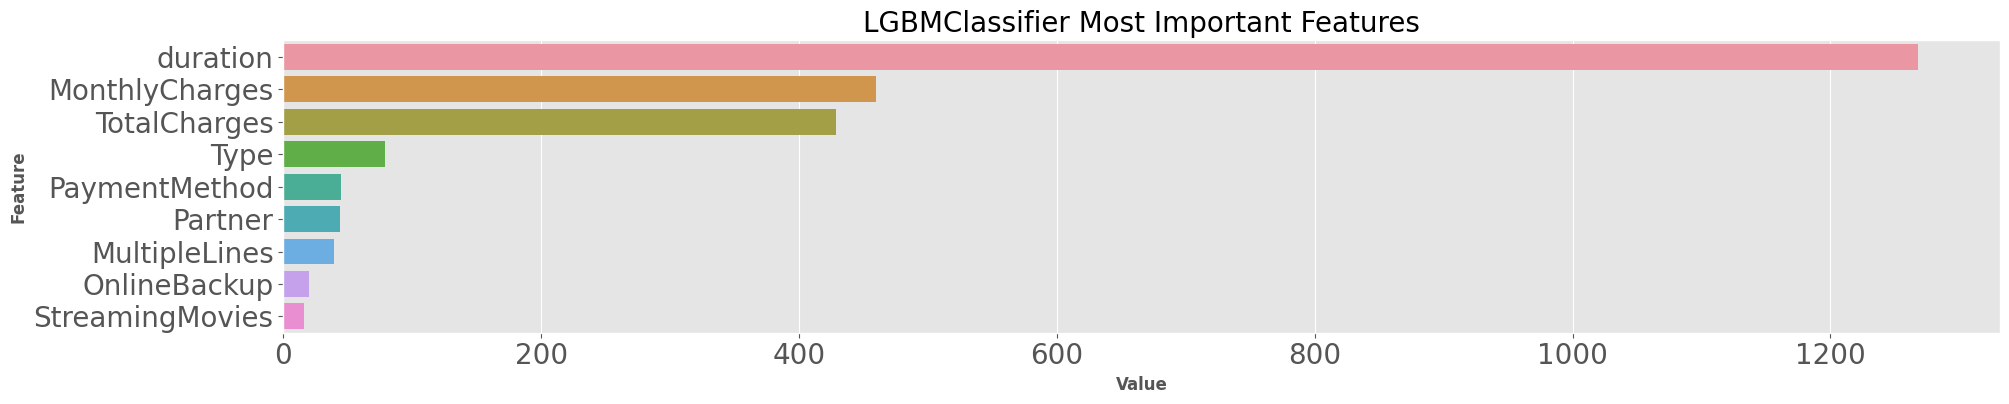

In [768]:
cols = [
    'Type',
    'PaymentMethod',
    'Partner',    
    'MultipleLines',
    'OnlineBackup',
    'StreamingMovies',
    'MonthlyCharges',
    'TotalCharges',
    'duration'
]

feature_imp=pd.DataFrame(
    sorted(
        zip(
            (
                model_grid
                .best_estimator_
                .named_steps['regressor']
                .feature_importances_
            ),
            cols
        )
    ), columns=['Value','Feature']
)
plt.figure(figsize=(19, 4))
sns.barplot(
    x="Value",
    y="Feature",
    data=feature_imp.sort_values(
        by="Value",
        ascending=False
    )
)
plt.title('LGBMClassifier Most Important Features', size=20)
plt.tight_layout()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

**Вывод:** 

На первом месте кол-во дней, прошедших с даты заключения договора.\
Далее идут, имеющие почти равные значения важности, сумма оплаты в месяц и итоговая сумма сборов.\
Далее срок, на который заключен договор.\
И на пятом месте метод оплаты.

Признаки, которые зависят от условий компании, это тип договора и метод оплаты.\
Это совпадает с выводами исследовательского анализа.

## Анализ матрицы ошибок

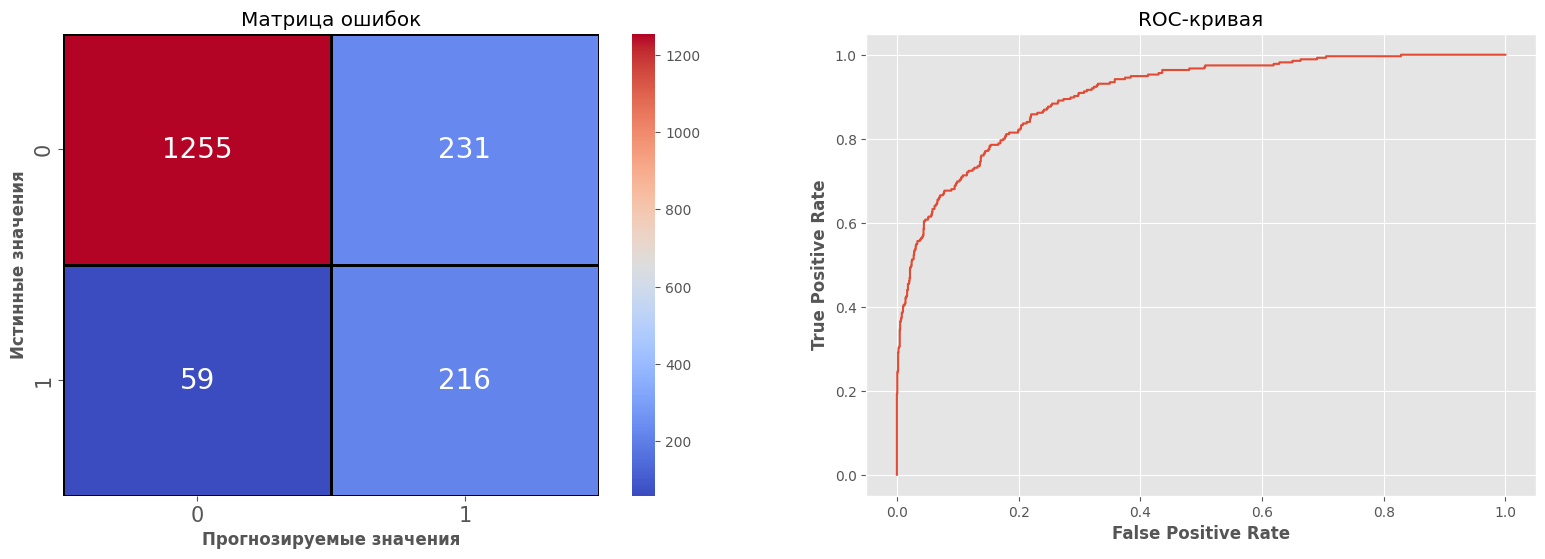

In [777]:
plt.figure(figsize=(19, 6))

ax = plt.subplot(1, 2, 1)

predicted_valid = probabilities_one > 0.5
cm = confusion_matrix(y_test, predicted_valid)
sns.heatmap(
    data=cm,
    annot=True,
    fmt='d',
    linewidths=2,
    linecolor='black',
    cmap='coolwarm',
    annot_kws={"fontsize":20}
)
plt.xlabel('Прогнозируемые значения')
plt.ylabel('Истинные значения')
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Матрица ошибок')

ax = plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, probabilities_one, pos_label=model_grid.classes_[1])
ax.plot(fpr, tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show();

In [766]:
test.shape

(1761, 21)

In [767]:
test.target.sum()

275

**Вывод:**

В нашей тестовой выборке данные от 1761 клиенте. 

Из них 275 покинули компанию.
* 216 предсказано верно.
* 59 неверно.

1486 не покинули компанию.
* 1255 предсказано верно.
* 231 неверно.

Нужно отметить, что часть клиентов, из ошибочно распределенных в целевую категорию, могли покинуть компанию после даты выгрузки базы.

В 78,5% случаев модель верно предсказывает целевой признак. Изменением порогового значения можно увеличить точность, но это приведет к увеличению количества клиентов, которые будут ошибочно определены моделью, как планирующие покинуть компанию. Это увеличит расходы на маркетинговые акции, направленные на удержание целевой категории клиентов. 